In [1]:
#IMPORT NEEDED LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc, precision_recall_curve, silhouette_score

#model
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.cluster import KMeans


import requests
import http.client 

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
from datetime import datetime, timedelta

In [ ]:
#SET UP AND DEF FUNCTION TO QUERY FROM CLICKHOUSE
http.client._MAXHEADERS = 1000
HOST = 'https://ch.itim.vn:443'
database = 'default'
user = '***********'
password = '**********'

#get query results from DataBase
def get_clickhouse_data(query, host = HOST, connection_timeout = 6000):
    r = requests.post(host, params = {'query': query,
                                      'database': database,
                                      'user':user,
                                      'password':password},timeout = connection_timeout)
    if r.status_code == 200:
        return r.text
    else:
        raise ValueError(r.text)
        
# convert query results to pandas DataFrame       
def get_clickhouse_df(query, host = HOST, connection_timeout = 6000):
    data = get_clickhouse_data(query, host, connection_timeout) 
    df = pd.read_csv(StringIO(data), sep = '\t')
    return df

In [149]:
#COLLECT DATA
# ref data 4 weeks from 2022-07-18 to 2022-08-14 - predict if an user churn in period 2022-08-15 to 2022-09-11
query1_14aug = '''
with 
ref_data as
(select
browser_id, event_date 
from browser_profiles.data
--extract from 2022-07-18 to 2022-08-14
where event_date between '2022-07-18' and '2022-08-14' --ref date
and os_name in ('android')
),
4w_past_ref_data as 
(select
browser_id, event_date 
from browser_profiles.data
--extract from Jan 1st 2022 to ref_date + 4w = 2022-09-11
where event_date between '2022-07-18' and '2022-09-11' --4 weeks from observed date
and os_name in ('android')
),
current_data as 
(select 
browser_id,
event_date
from browser_profiles.data
where event_date >= '2022-07-18'
and os_name in ('android')
)
select 
--browser_id 
lad_ref.browser_id as browser_id,
--last active date at ref.date, ref.date + 4w, current 
--1.TARGET
case when lad_ref.last_active_date = lad_4w_past_ref.last_active_date then 1
else 0 end as churn_2w,
case when lad_ref.last_active_date = lad_current.last_active_date then 1
else 0 end as churn_current,
lad_ref.last_active_date, 
lad_4w_past_ref.last_active_date,
lad_current.last_active_date,
lad_ref.first_active_date_2022,
case when fad.first_active_date < '2021-01-01' then date('2021-01-01')
else fad.first_active_date end as first_active_date,
--2.ENGAGEMENT 
lad_ref.active_days_last_4w,
date_diff(day, lad_ref.last_active_date, date('2022-08-14')) as inactive_days_till_ref,
--3.FEATURE
date('2022-08-14') - fad.first_active_date as seniority_till_ref,
lad_ref.last_active_date - fad.first_active_date as seniority_till_last_active
from 
--last active date, number of active days in active period. at ref.date
	(select browser_id, 
	max(event_date) as last_active_date,
	min(event_date) as first_active_date_2022,
	count(distinct event_date) as active_days_last_4w
	from ref_data
	group by browser_id) as lad_ref
	left join 
--last active date at 4 weeks after ref.date
	(select browser_id, 
	max(event_date) as last_active_date
	from 4w_past_ref_data
	group by browser_id) as lad_4w_past_ref
	on lad_ref.browser_id = lad_4w_past_ref.browser_id	
	left join 
--last active date till current
	(select browser_id,
	max(event_date) as last_active_date
	from current_data 
	group by browser_id) as lad_current
	on lad_ref.browser_id = lad_current.browser_id
	left join 
--first active date/week
	(select browser_id, 
	first_date as first_active_date
	from aggregated.browser_first_date bfd
	where first_date >= '2021-01-01') as fad
	on lad_ref.browser_id = fad.browser_id	
FORMAT TabSeparatedWithNames
'''
df1=get_clickhouse_df(query1_14aug)

query2_14aug = '''
with 
ref_data as
(select
browser_id, event_date 
from browser_profiles.data
--extract from 2022-07-18 to 2022-08-14
where event_date between '2022-07-18' and '2022-08-14' --ref date
and os_name in ('android')
)
select 
--browser_id 
base.browser_id as browser_id,
--3. FEATURES
case when other_feature_users.total_dowload_events_last_4w = 0 then 0
else 1 end as is_dowload_user,
case when other_feature_users.total_cinema_events_last_4w = 0 then 0
else 1 end as is_cinema_user,
case when other_feature_users.total_pin_events_last_4w = 0 then 0
else 1 end as is_pin_user,
case when other_feature_users.total_headset_events_last_4w = 0 then 0
else 1 end as is_headset_user,
case when search_users.total_queries_last_4w = 0 then 0
else 1 end as is_search_user,
case when nf_users.browser_id = '' then 0
else 1 end as is_nf_user,
--2. ENGAGEMENT
other_feature_users.total_sessions_last_4w,
other_feature_users.total_dowload_events_last_4w,
other_feature_users.total_cinema_events_last_4w,
other_feature_users.total_pin_events_last_4w,
other_feature_users.total_headset_events_last_4w,
search_users.total_queries_last_4w,
nf_users.total_clicks_last_4w
from 
(select distinct browser_id 
from ref_data) as base
left join 
-- total sessions, dowload events, cinema events, pin events, headset events last 4 weeks from ref.date 
(select 
browser_id, 
uniqExact(g.session_id) as total_sessions_last_4w,
countIf(g.name in ('evt_download_audio', 'evt_download_video')) as total_dowload_events_last_4w,
countIf(g.name IN ('act_media_player_assistant_cinemamode','act_pip_cinemamode')) as total_cinema_events_last_4w,
countIf(g.name IN ('act_media_player_assistant_pip')) as total_pin_events_last_4w,
countIf(g.name IN ('act_media_player_assistant_headset')) as total_headset_events_last_4w
from browser_metrics.data 
array join generic_event as g 
where event_date BETWEEN '2022-07-18' and '2022-08-14'
and os_name in ('android')
group by browser_id
) as other_feature_users
on base.browser_id = other_feature_users.browser_id
left join 
--search users / total search queries last 4 weeks from ref.date
(select 
user_id as browser_id,
uniqExact(event_date) as total_search_days_last_4w,
count() as total_queries_last_4w
from aggregated.search_queries 
where event_date between '2022-07-18' and '2022-08-14'
and os_name in ('android')
group by browser_id
) as search_users
on base.browser_id = search_users.browser_id
left join 
--newsfeed users/ total clicks newsfeed last 4 weeks from ref.date
(select 
browser_id, countIf(action_type = 'click') as total_clicks_last_4w
from newsfeed.log l 
where source = 'news_feed'
and event_date between '2022-07-18' and '2022-08-14'
and ((action_type = 'impression' and row > 0) or (action_type = 'click'))
group by browser_id) as nf_users
on base.browser_id = nf_users.browser_id
FORMAT TabSeparatedWithNames
'''
df2=get_clickhouse_df(query2_14aug)

#merger df1 and df2
df_final_14aug = pd.merge(df1, df2, how ='inner', on = ['browser_id'])
df_final_14aug.to_pickle('df_final_14aug.pkl')  

,browser_id,churn_4w,churn_current,lad_ref.last_active_date,lad_4w_past_ref.last_active_date,lad_current.last_active_date,lad_ref.first_active_date_2022,first_active_date,lad_ref.active_days_last_4w,inactive_days_till_ref,seniority_till_ref,seniority_till_last_active
0,0dfb67fc-fb13-b1c0-5eab-d94415756cec.ORKBfH8zP...,0,0,2022-08-12,2022-09-01,2022-09-01,2022-08-06,2022-04-23,5,2,113,111
1,24d5cab8-fed2-7f00-1594-5f394b5b5a8b.6H4vj7N6c...,0,0,2022-08-14,2022-09-11,2022-09-22,2022-07-18,2022-06-09,25,0,66,66
2,d5d284a8-457e-481d-bbcf-72271f12d5bc.-Jgrb-gyb...,1,1,2022-07-19,2022-07-19,2022-07-19,2022-07-19,2021-01-01,1,26,19218,19192
3,c2e5f204-974d-4bf9-355b-659ed726635f.qOd4XvEhC...,0,0,2022-08-11,2022-09-11,2022-09-20,2022-07-22,2021-11-26,11,3,261,258
4,886095cd-734c-6fa2-f734-477efa56186e.ImEpllDgM...,0,0,2022-08-14,2022-09-11,2022-09-22,2022-07-18,2022-06-19,28,0,56,56


In [2]:
#IMPORT DATASET WITH X = 14 DAYS => churn_2w
df_final_30jan = pd.read_pickle('data/df_final_2w_full/df_final_30jan.pkl').rename(columns = {'total_sessions_last_4w': 'other_feature_users.total_sessions_last_4w'}).reset_index()
df_final_27feb = pd.read_pickle('data/df_final_2w_full/df_final_27feb.pkl').rename(columns = {'total_sessions_last_4w': 'other_feature_users.total_sessions_last_4w'}).reset_index()
df_final_27mar = pd.read_pickle('data/df_final_2w_full/df_final_27mar.pkl').rename(columns = {'total_sessions_last_4w': 'other_feature_users.total_sessions_last_4w'}).reset_index()
df_final_24apr = pd.read_pickle('data/df_final_2w_full/df_final_24apr.pkl').rename(columns = {'total_sessions_last_4w': 'other_feature_users.total_sessions_last_4w'}).reset_index()
df_final_22may = pd.read_pickle('data/df_final_2w_full/df_final_22may.pkl').rename(columns = {'total_sessions_last_4w': 'other_feature_users.total_sessions_last_4w'}).reset_index()
df_final_19jun = pd.read_pickle('data/df_final_2w_full/df_final_19jun.pkl').rename(columns = {'total_sessions_last_4w': 'other_feature_users.total_sessions_last_4w'}).reset_index() 
df_final_17jul = pd.read_pickle('data/df_final_2w_full/df_final_17jul.pkl').rename(columns = {'total_sessions_last_4w': 'other_feature_users.total_sessions_last_4w'}).reset_index() 
df_final_14aug = pd.read_pickle('data/df_final_2w_full/df_final_14aug.pkl').rename(columns = {'total_sessions_last_4w': 'other_feature_users.total_sessions_last_4w'}).reset_index() 

#fix error value seniority_till_last_active and seniority_till_ref for the record whose first_active_date = 1970-01-01
df_list = [df_final_30jan, df_final_27feb, df_final_27mar, df_final_24apr, df_final_22may, df_final_19jun, df_final_17jul, df_final_14aug]
for i in df_list:
    i['seniority_till_last_active'][i['seniority_till_last_active'] > 1000] = i['seniority_till_last_active'][i['seniority_till_last_active'] < 1000].max()
    i['seniority_till_ref'][i['seniority_till_ref'] > 1000] = i['seniority_till_ref'][i['seniority_till_ref'] < 1000].max()    

#add ref.date to each dataset
df_final_30jan['ref_date'] = pd.to_datetime('2022-01-30')
df_final_27feb['ref_date'] = pd.to_datetime('2022-02-27')
df_final_27mar['ref_date'] = pd.to_datetime('2022-03-27')
df_final_24apr['ref_date'] = pd.to_datetime('2022-04-24')
df_final_22may['ref_date'] = pd.to_datetime('2022-05-22')
df_final_19jun['ref_date'] = pd.to_datetime('2022-06-19')
df_final_17jul['ref_date'] = pd.to_datetime('2022-07-17')
df_final_14aug['ref_date'] = pd.to_datetime('2022-08-14')

# #combine all dataset with ref.date
# df_final = pd.concat(df_list, ignore_index=True)

#normalize dataset
for i in df_list:
    #Min max rescale:
    a = MinMaxScaler().fit_transform(i[[
        'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
        'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
        'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
        'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active']])

    minmax_rescaled = pd.DataFrame(a, columns=[
        'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
        'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
        'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
        'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active'])

    minmax_rescaled_columns = []
    for x in minmax_rescaled.columns:
        x = 'minmax_rescaled_' + x
        minmax_rescaled_columns.append(x)

    i[minmax_rescaled_columns] = minmax_rescaled[minmax_rescaled.columns]   
    
    #Standard rescale:
    b = StandardScaler().fit_transform(i[[
        'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
        'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
        'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
        'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active']])

    standard_rescaled = pd.DataFrame(b, columns=[
        'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
        'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
        'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
        'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active'])

    standard_rescaled_columns = []
    for x in standard_rescaled.columns:
        x = 'standard_rescaled_' + x
        standard_rescaled_columns.append(x)

    i[standard_rescaled_columns] = standard_rescaled[standard_rescaled.columns]       
    

C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\2181232406.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i['seniority_till_last_active'][i['seniority_till_last_active'] > 1000] = i['seniority_till_last_active'][i['seniority_till_last_active'] < 1000].max()
C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\2181232406.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i['seniority_till_ref'][i['seniority_till_ref'] > 1000] = i['seniority_till_ref'][i['seniority_till_ref'] < 1000].max()


In [4]:
print('A. EXPLORATORY DATA ANALYSIS')

A. EXPLORATORY DATA ANALYSIS


In [105]:
for i in df_final_30jan.columns[13:19]:
    df_final_30jan[[i, 'churn_2w']].groupby([i]).mean()

C:\Users\manhdang\AppData\Local\Temp\ipykernel_9800\245331875.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


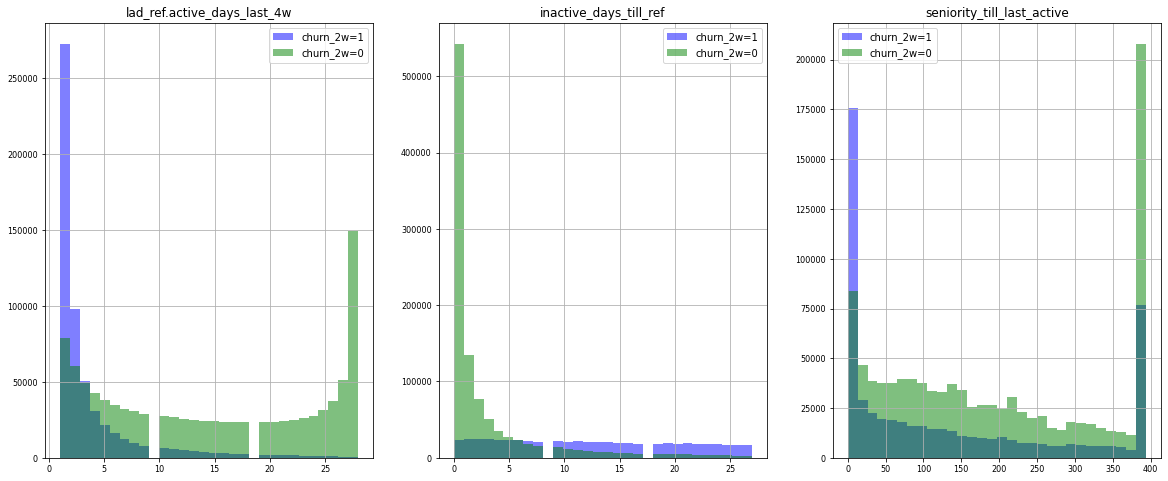

In [19]:
continuous_var = ['lad_ref.active_days_last_4w', 
'inactive_days_till_ref', 'seniority_till_last_active', 
'other_feature_users.total_sessions_last_4w',
'other_feature_users.total_dowload_events_last_4w',
'other_feature_users.total_cinema_events_last_4w',
'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w',
'search_users.total_queries_last_4w', 'nf_users.total_clicks_last_4w']

fig, axes = plt.subplots(1, 3)
for i in range(3):
    df_final_30jan[continuous_var[i]][(df_final_30jan['churn_2w'] == 1)].hist(label = 'churn_2w=1', figsize = (20, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'blue', alpha = 0.5, ax=axes[i])
    df_final_30jan[continuous_var[i]][(df_final_30jan['churn_2w'] == 0)].hist(label = 'churn_2w=0', figsize = (20, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'green', alpha = 0.5, ax=axes[i])
    axes[i].set_title(continuous_var[i])
    axes[i].legend()
fig.show()



In [133]:
continuous_var = ['lad_ref.active_days_last_4w', 
'inactive_days_till_ref', 'seniority_till_last_active', 
'other_feature_users.total_sessions_last_4w',
'other_feature_users.total_dowload_events_last_4w',
'other_feature_users.total_cinema_events_last_4w',
'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w',
'search_users.total_queries_last_4w', 'nf_users.total_clicks_last_4w']

df_final_30jan[['other_feature_users.total_sessions_last_4w',
'other_feature_users.total_dowload_events_last_4w',
'other_feature_users.total_cinema_events_last_4w',
'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w',
'search_users.total_queries_last_4w', 'nf_users.total_clicks_last_4w', 
'churn_2w']].groupby(['churn_2w']).mean().rename(columns = {'lad_ref.active_days_last_4w': 'active_days_last_4w',
                                                                                                                                  'other_feature_users.total_sessions_last_4w': 'total_sessions',
                                                                                                                                  'other_feature_users.total_dowload_events_last_4w': 'total_dowload_events',
                                                                                                                                  'other_feature_users.total_cinema_events_last_4w': 'total_cinema_events',
                                                                                                                                  'other_feature_users.total_pin_events_last_4w': 'total_pin_events',
                                                                                                                                  'other_feature_users.total_headset_events_last_4w': 'total_headset_events',
                                                                                                                                  'search_users.total_queries_last_4w': 'total_queries',
                                                                                                                                  'nf_users.total_clicks_last_4w': 'total_clicks'})

,total_sessions,total_dowload_events,total_cinema_events,total_pin_events,total_headset_events,total_queries,total_clicks
churn_2w,,,,,,,
0,36.169026,76.384340,11.149057,0.548172,0.484660,29.090767,1.580793
1,6.799199,7.232969,2.037874,0.183645,0.071431,6.729588,0.228841


C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\manhdang\anac

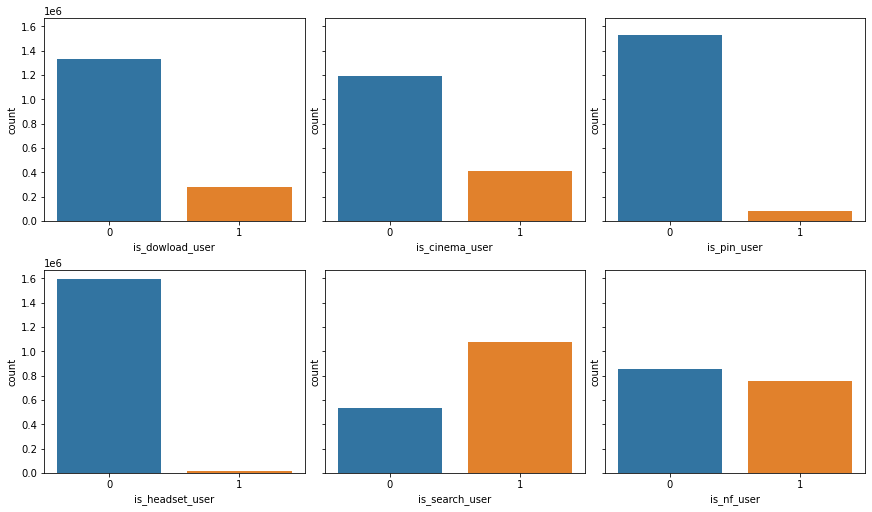

In [102]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True, constrained_layout = True)
sns.countplot(df_final_30jan.columns[13:19][0], data=df_final_30jan, ax=axes[0,0])
sns.countplot(df_final_30jan.columns[13:19][1], data=df_final_30jan, ax=axes[0,1])
sns.countplot(df_final_30jan.columns[13:19][2], data=df_final_30jan, ax=axes[0,2])
sns.countplot(df_final_30jan.columns[13:19][3], data=df_final_30jan, ax=axes[1,0])
sns.countplot(df_final_30jan.columns[13:19][4], data=df_final_30jan, ax=axes[1,1])
sns.countplot(df_final_30jan.columns[13:19][5], data=df_final_30jan, ax=axes[1,2])
fig.savefig('features.png')

In [5]:
print('B. CUSTOMER SEGMENTATION')

B. CUSTOMER SEGMENTATION


In [20]:
# RFS Segmentation: Recency - Frequency - Seniority 
df_segmentation = df_final_30jan[[
'browser_id',
#recency
'inactive_days_till_ref', 'standard_rescaled_inactive_days_till_ref',
#frequency
'lad_ref.active_days_last_4w', 'standard_rescaled_lad_ref.active_days_last_4w',
#seniority
'seniority_till_last_active', 'standard_rescaled_seniority_till_last_active']]

df_segmentation_standard_rescaled = df_final_30jan[[
#recency
'standard_rescaled_inactive_days_till_ref',
#frequency
'standard_rescaled_lad_ref.active_days_last_4w',
#seniority
'standard_rescaled_seniority_till_last_active']]

df_segmentation.head()

,browser_id,inactive_days_till_ref,standard_rescaled_inactive_days_till_ref,lad_ref.active_days_last_4w,standard_rescaled_lad_ref.active_days_last_4w,seniority_till_last_active,standard_rescaled_seniority_till_last_active
0,9568155f-a5ac-0a41-03eb-fa751f5151dd.W12Qx9Umm...,11,0.603753,1,-0.987665,394,1.561524
1,e1b20a76-23b3-e5a5-5164-2d0261a3173d.z4MCm-znN...,11,0.603753,1,-0.987665,116,-0.395682
2,4cc2fd28-e3ee-4aae-a880-a1e28258796c.iW7T6IiUW...,0,-0.793865,1,-0.987665,0,-1.212357
3,c6367847-7983-3f83-a203-fc49305eb493.0yHHqSf8p...,4,-0.285641,9,-0.175939,394,1.561524
4,6648e0a2-1464-e712-2828-01d9cb6c3873.2EUD-ByiS...,1,-0.666809,2,-0.886199,8,-1.156035


In [21]:
# Define rfs_level function
def recency_level(df):
    if df['inactive_days_till_ref'] <= 7:
        return "0-7 days not active"
    elif ((df['inactive_days_till_ref'] > 7) and (df['inactive_days_till_ref'] <= 14)):
        return '7-14 days not active'
    elif ((df['inactive_days_till_ref'] > 14) and (df['inactive_days_till_ref'] <= 21)):
        return '14-21 days not active'
    else:
        return '21-28 days not active'
    
def seniority_level(df):
    if df['seniority_till_last_active'] <= 28:
        return "<= 28d"
    elif ((df['seniority_till_last_active'] > 28) and (df['seniority_till_last_active'] <= 90)):
        return '28-90d'
    else:
        return '>90d'

def frequency_level(df):
    if df['lad_ref.active_days_last_4w'] <= 7:
        return "<= 7d active"
    elif ((df['lad_ref.active_days_last_4w'] > 7) and (df['seniority_till_last_active'] <= 14)):
        return '7-14d active'
    else:
        return '>14d'    
    
# Create a new variable RFM_Level
df_segmentation['R'] = df_segmentation.apply(recency_level, axis=1)
df_segmentation['F'] = df_segmentation.apply(frequency_level, axis=1)
df_segmentation['S'] = df_segmentation.apply(seniority_level, axis=1)
df_segmentation

C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\4185492435.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segmentation['R'] = df_segmentation.apply(recency_level, axis=1)
C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\4185492435.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segmentation['F'] = df_segmentation.apply(frequency_level, axis=1)
C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\4185492435.py:31: SettingWithCopyWarning: 
A value is trying to be

,browser_id,inactive_days_till_ref,standard_rescaled_inactive_days_till_ref,lad_ref.active_days_last_4w,standard_rescaled_lad_ref.active_days_last_4w,seniority_till_last_active,standard_rescaled_seniority_till_last_active,R,F,S
0,9568155f-a5ac-0a41-03eb-fa751f5151dd.W12Qx9Umm...,11,0.603753,1,-0.987665,394,1.561524,7-14 days not active,<= 7d active,>90d
1,e1b20a76-23b3-e5a5-5164-2d0261a3173d.z4MCm-znN...,11,0.603753,1,-0.987665,116,-0.395682,7-14 days not active,<= 7d active,>90d
2,4cc2fd28-e3ee-4aae-a880-a1e28258796c.iW7T6IiUW...,0,-0.793865,1,-0.987665,0,-1.212357,0-7 days not active,<= 7d active,<= 28d
3,c6367847-7983-3f83-a203-fc49305eb493.0yHHqSf8p...,4,-0.285641,9,-0.175939,394,1.561524,0-7 days not active,>14d,>90d
4,6648e0a2-1464-e712-2828-01d9cb6c3873.2EUD-ByiS...,1,-0.666809,2,-0.886199,8,-1.156035,0-7 days not active,<= 7d active,<= 28d
...,...,...,...,...,...,...,...,...,...,...
1609137,c1ff4f43-4d1d-cbfb-6210-05550a4dc3cf.9Edqr4pFy...,9,0.349640,19,0.838717,311,0.977178,7-14 days not active,>14d,>90d
1609138,d697b868-87c6-a326-bf4d-8c663a7a2122.uueuG3qNH...,1,-0.666809,14,0.331389,18,-1.085632,0-7 days not active,>14d,<= 28d
1609139,1ba5476d-f08d-92a4-410d-041346e90657.sFdiSuz-e...,5,-0.158584,3,-0.784733,394,1.561524,0-7 days not active,<= 7d active,>90d
1609140,75427e9a-966e-7e32-66c1-6ddc91e932b7.K6j85PmDR...,19,1.620202,2,-0.886199,1,-1.205317,14-21 days not active,<= 7d active,<= 28d


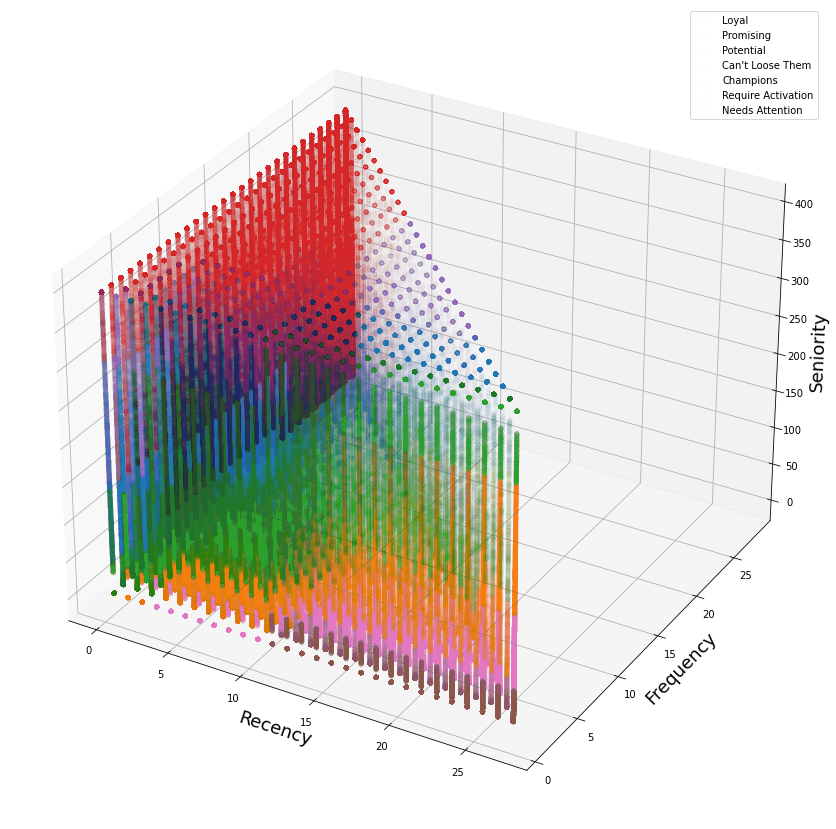

In [17]:
# Creating figure
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
for cluster in df_segmentation['RFS_Level'].unique() :
    result_cluster = df_segmentation.loc[df_segmentation['RFS_Level'] == cluster]
    ax.scatter(result_cluster['inactive_days_till_ref'], result_cluster['lad_ref.active_days_last_4w'],  result_cluster['seniority_till_last_active'], label=cluster, alpha=0.01, cmap='viridis')
ax.set_xlabel('Recency', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_zlabel('Seniority', fontsize=18)
ax.legend()
# show plot
plt.show()

C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\4139223405.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


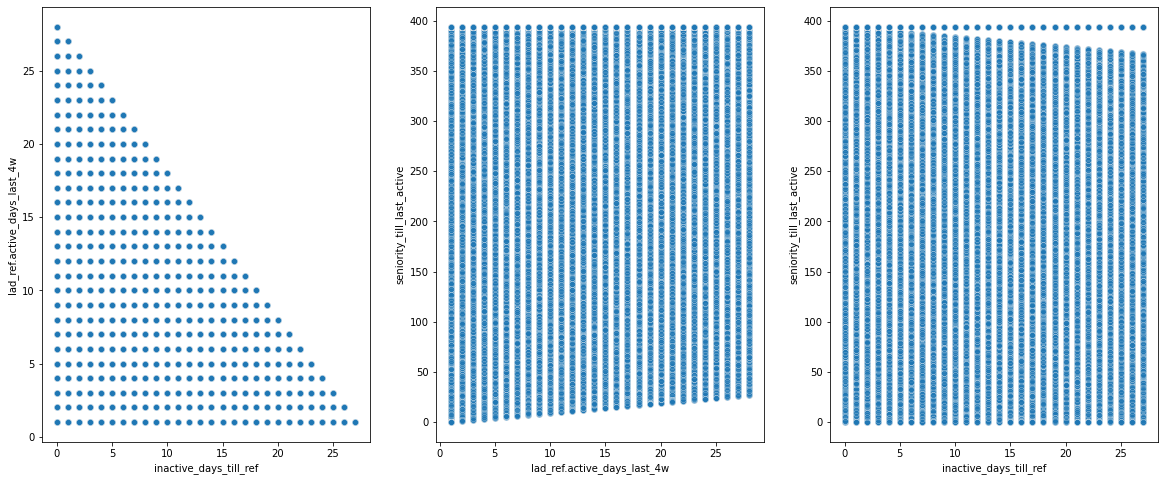

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (20, 8))
m = 0
for (i, j) in [('inactive_days_till_ref', 'lad_ref.active_days_last_4w'), ('lad_ref.active_days_last_4w', 'seniority_till_last_active'), ('inactive_days_till_ref', 'seniority_till_last_active')]:
    sns.scatterplot(data = df_segmentation, x = i, y = j, ax = axes[m], alpha = 0.5)
    m += 1
fig.show()

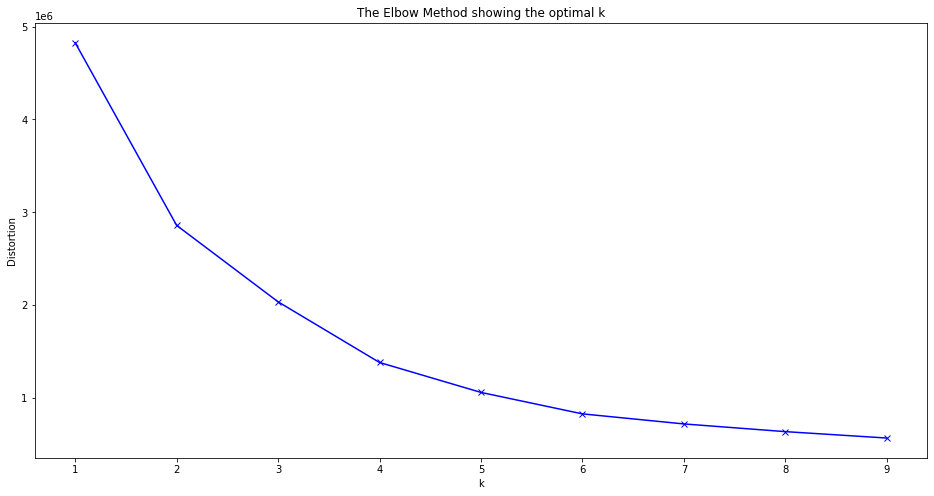

In [6]:
scaled_segmentation_features = np.array(df_segmentation_standard_rescaled)
distortions = []
for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_segmentation_features)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [18]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(scaled_segmentation_features)
pred_y

array([3, 2, 1, ..., 3, 2, 0])

C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_15220\3955758334.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\manhdang_coccoc\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


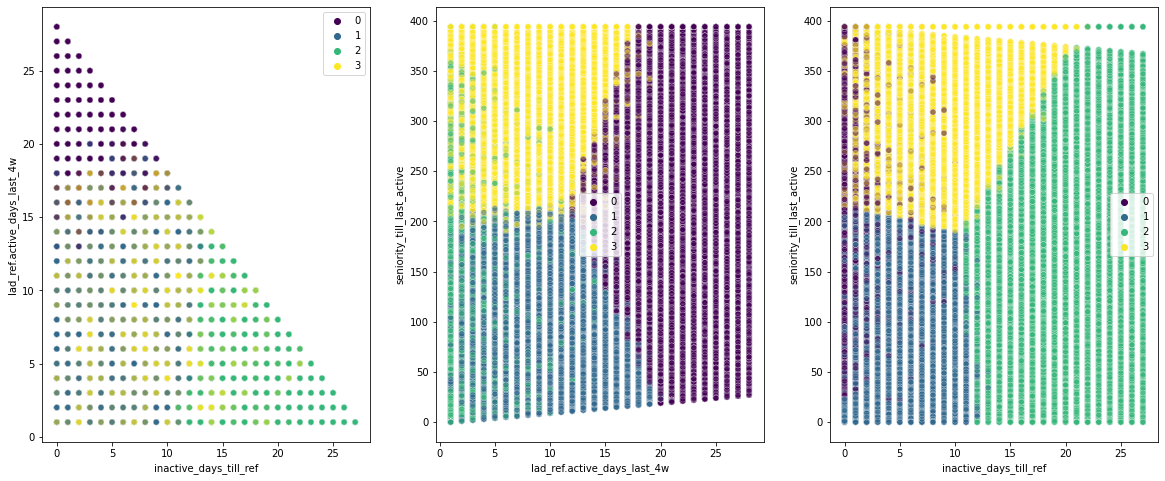

In [16]:
fig, axes = plt.subplots(1, 3, figsize = (20, 8))
m = 0
for (i, j) in [('inactive_days_till_ref', 'lad_ref.active_days_last_4w'), ('lad_ref.active_days_last_4w', 'seniority_till_last_active'), ('inactive_days_till_ref', 'seniority_till_last_active')]:
    sns.scatterplot(data = df_segmentation, x = i, y = j, ax = axes[m], alpha = 0.5, hue = pred_y, palette = 'viridis')
    m += 1
fig.show()

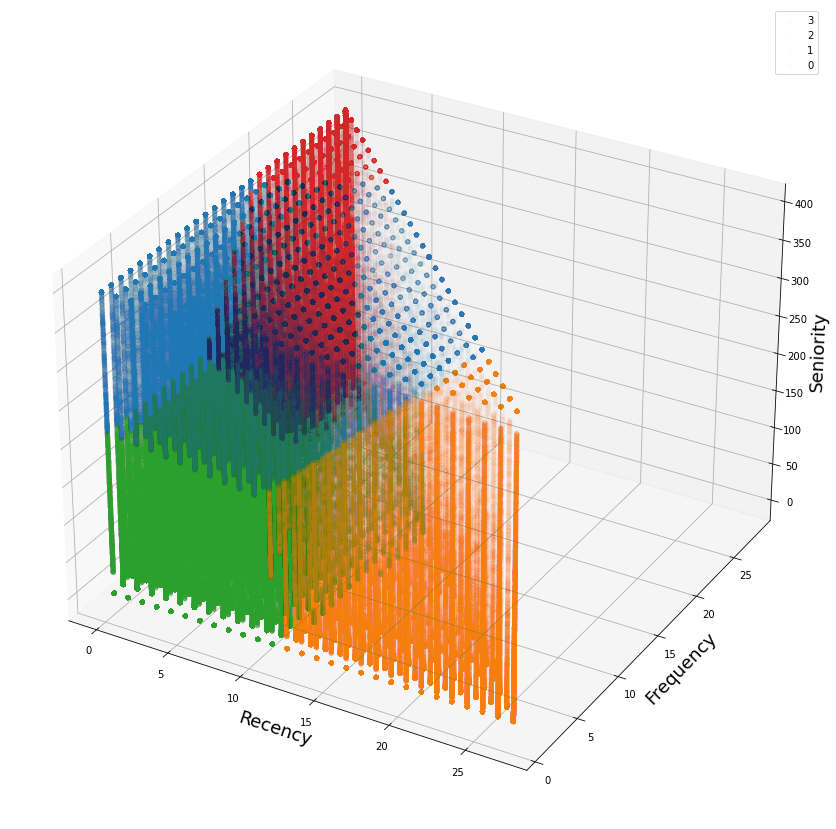

In [19]:
# Creating figure
df_segmentation['kmean_group'] = pred_y

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
for cluster in df_segmentation['kmean_group'].unique() :
    result_cluster = df_segmentation.loc[df_segmentation['kmean_group'] == cluster]
    ax.scatter(result_cluster['inactive_days_till_ref'], result_cluster['lad_ref.active_days_last_4w'],  result_cluster['seniority_till_last_active'], label=cluster, alpha=0.01, cmap='viridis')
ax.set_xlabel('Recency', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_zlabel('Seniority', fontsize=18)
ax.legend()
# show plot
plt.show()

In [20]:
print('-----------Start training with data 30 jan---------')

-----------Start training with data 30 jan---------


C:\Users\manhdang_coccoc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


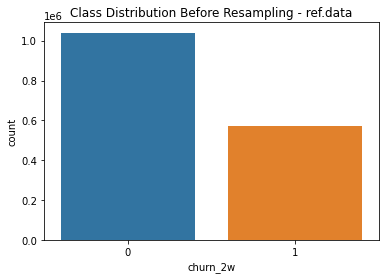

C:\Users\manhdang_coccoc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


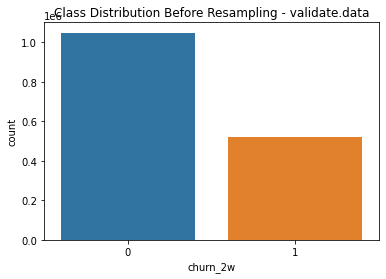

In [24]:
#Class Distribution of Unsampled data
#train model with ref.data = 30jan and validate.data = 27feb
data_ref = df_final_30jan[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user',
#Target
        'churn_2w']]

#using data at ref.date = 27feb to validate model 
data_validate = df_final_27feb[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user',
#Target
        'churn_2w']]

X_validate = data_validate[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user'
]]

Y_validate = data_validate[['churn_2w']]

#Class Distribution of Unsampled ref.data data
sns.countplot('churn_2w', data=data_ref).set_title('Class Distribution Before Resampling - ref.data')
plt.show()
sns.countplot('churn_2w', data=data_validate).set_title('Class Distribution Before Resampling - validate.data')
plt.show()

C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\2585313285.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
C:\Users\manhdang_coccoc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution After Resampling')

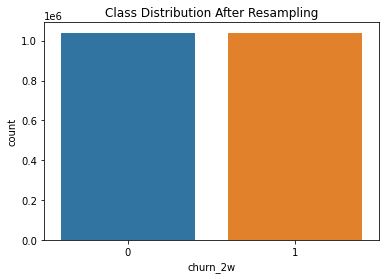

In [25]:
#Separating positive class (churn=1) and negative class (churn=0)
X_no = data_ref[data_ref['churn_2w'] == 0]
X_yes = data_ref[data_ref['churn_2w'] == 1]

#Upsampling the positive class
X_yes_upsampled = X_yes.sample(n=len(X_no), replace=True, random_state=42)

#Combining positive and negative class and checking class distribution
X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
sns.countplot('churn_2w', data=X_upsampled).set_title('Class Distribution After Resampling')

In [26]:
# Create Train & Test Data with upsampled data of X_yes
X_ref = X_upsampled.drop(['churn_2w'], axis=1) #features (independent variables)
Y_ref = X_upsampled['churn_2w'] #target (dependent variable)

X_train, X_test, Y_train, Y_test = train_test_split(X_ref, Y_ref, test_size=0.2)

LOGISTIC REGRESSION - REF.DATA RESULT
              precision    recall  f1-score   support

           0       0.84      0.79      0.81    208221
           1       0.80      0.85      0.82    207557

    accuracy                           0.82    415778
   macro avg       0.82      0.82      0.82    415778
weighted avg       0.82      0.82      0.82    415778


True Positives(TP)  =  175720

True Negatives(TN)  =  164236

False Positives(FP) =  43985

False Negatives(FN) =  31837


<AxesSubplot:>

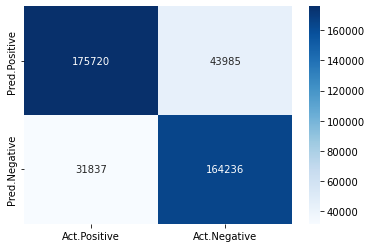

In [67]:
#Logistic Regression
model_lr = LogisticRegression()
result = model_lr.fit(X_train, Y_train)
prediction_test = model_lr.predict(X_test)
# Print the prediction accuracy
print('LOGISTIC REGRESSION - REF.DATA RESULT')
print(classification_report(Y_test, prediction_test))
result_test = pd.DataFrame()
result_test['churn_2w'] = Y_test
result_test['pred_churn'] = prediction_test
print('\nTrue Positives(TP)  = ', sum((result_test['pred_churn'] == 1) & (result_test['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((result_test['pred_churn'] == 0) & (result_test['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((result_test['pred_churn'] == 1) & (result_test['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((result_test['pred_churn'] == 0) & (result_test['churn_2w'] != 0)))

cf_matrix = np.array([[sum((result_test['pred_churn'] == 1) & (result_test['churn_2w'] == 1)), sum((result_test['pred_churn'] == 1) & (result_test['churn_2w'] != 1))],
                      [sum((result_test['pred_churn'] == 0) & (result_test['churn_2w'] != 0)), sum((result_test['pred_churn'] == 0) & (result_test['churn_2w'] == 0))]])
x_axis_labels = ['Act.Positive', 'Act.Negative']
y_axis_labels = ['Pred.Positive', 'Pred.Negative']
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='g')  # cmap='OrRd'

LOGISTIC REGRESSION - VALIDATION DATA RESULT
              precision    recall  f1-score   support

           0       0.91      0.80      0.85   1047644
           1       0.68      0.85      0.75    521826

    accuracy                           0.81   1569470
   macro avg       0.80      0.82      0.80   1569470
weighted avg       0.83      0.81      0.82   1569470


True Positives(TP)  =  442938

True Negatives(TN)  =  835828

False Positives(FP) =  211816

False Negatives(FN) =  78888


<AxesSubplot:>

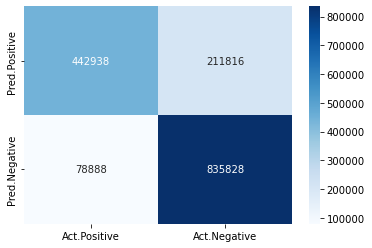

In [69]:
#validate model with validate.data 
Y_validate = data_validate[['churn_2w']]
validation_test = model_lr.predict(X_validate)
# Print the prediction accuracy
print('LOGISTIC REGRESSION - VALIDATION DATA RESULT')
print(classification_report(Y_validate, validation_test))
result_validation = pd.DataFrame()
result_validation['churn_2w'] = Y_validate
result_validation['pred_churn'] = validation_test
print('\nTrue Positives(TP)  = ', sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] != 0)))

cf_matrix = np.array([[sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] == 1)), sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] != 1))],
                      [sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] != 0)), sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] == 0))]])
x_axis_labels = ['Act.Positive', 'Act.Negative']
y_axis_labels = ['Pred.Positive', 'Pred.Negative']
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='g')  # cmap='OrRd'

In [70]:
# To get the weights of all the variables
weights = pd.Series(model_lr.coef_[0],
index=X_test.columns.values)
weights.sort_values(ascending = False)

Normalized_other_feature_users.total_sessions_last_4w          8.864561
Normalized_search_users.total_queries_last_4w                  5.840439
Normalized_inactive_days_till_ref                              3.406598
is_pin_user                                                    0.184317
Normalized_nf_users.total_clicks_last_4w                       0.006576
Normalized_other_feature_users.total_dowload_events_last_4w    0.006087
is_nf_user                                                    -0.052245
Normalized_other_feature_users.total_headset_events_last_4w   -0.102128
is_dowload_user                                               -0.102763
is_search_user                                                -0.113342
is_headset_user                                               -0.123718
is_cinema_user                                                -0.127682
Normalized_other_feature_users.total_cinema_events_last_4w    -0.190677
Normalized_other_feature_users.total_pin_events_last_4w       -0

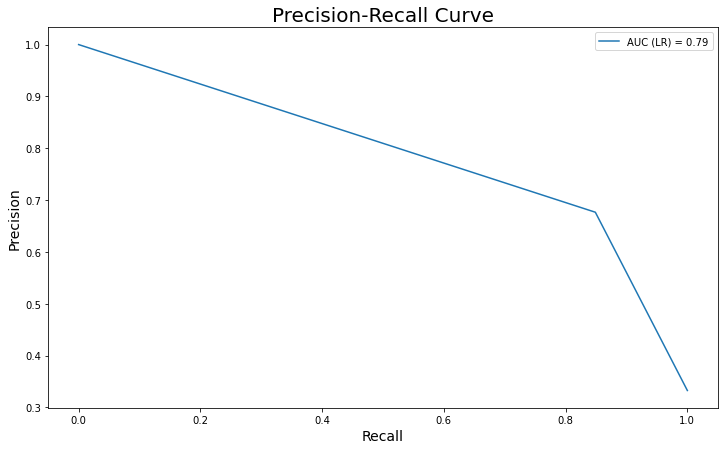

In [74]:
precision_lr, recall_lr, _ = precision_recall_curve(Y_validate, validation_test)
auc_lr = auc(recall_lr, precision_lr)
plt.figure(figsize=(12, 7))
plt.plot(recall_lr, precision_lr, label=f'AUC (LR) = {auc_lr:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend()

XGBOOST - REF.DATA RESULT
              precision    recall  f1-score   support

           0       0.87      0.79      0.83    207777
           1       0.81      0.89      0.85    208001

    accuracy                           0.84    415778
   macro avg       0.84      0.84      0.84    415778
weighted avg       0.84      0.84      0.84    415778


True Positives(TP)  =  184216

True Negatives(TN)  =  164607

False Positives(FP) =  43170

False Negatives(FN) =  23785


<AxesSubplot:>

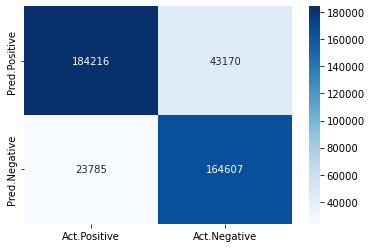

In [27]:
#XGBClassifier
model_xg = XGBClassifier()
result = model_xg.fit(X_train, Y_train)
prediction_test = model_xg.predict(X_test)
# Print the prediction accuracy
print('XGBOOST - REF.DATA RESULT')
print(classification_report(Y_test, prediction_test))
result_test = pd.DataFrame()
result_test['churn_2w'] = Y_test
result_test['pred_churn'] = prediction_test
print('\nTrue Positives(TP)  = ', sum((result_test['pred_churn'] == 1) & (result_test['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((result_test['pred_churn'] == 0) & (result_test['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((result_test['pred_churn'] == 1) & (result_test['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((result_test['pred_churn'] == 0) & (result_test['churn_2w'] != 0)))

cf_matrix = np.array([[sum((result_test['pred_churn'] == 1) & (result_test['churn_2w'] == 1)), sum((result_test['pred_churn'] == 1) & (result_test['churn_2w'] != 1))],
                      [sum((result_test['pred_churn'] == 0) & (result_test['churn_2w'] != 0)), sum((result_test['pred_churn'] == 0) & (result_test['churn_2w'] == 0))]])
x_axis_labels = ['Act.Positive', 'Act.Negative']
y_axis_labels = ['Pred.Positive', 'Pred.Negative']
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='g')  # cmap='OrRd'

XGBOOST - VALIDATION DATA RESULT
              precision    recall  f1-score   support

           0       0.93      0.80      0.86   1047644
           1       0.69      0.89      0.78    521826

    accuracy                           0.83   1569470
   macro avg       0.81      0.84      0.82   1569470
weighted avg       0.85      0.83      0.83   1569470


True Positives(TP)  =  462805

True Negatives(TN)  =  839407

False Positives(FP) =  208237

False Negatives(FN) =  59021


<AxesSubplot:>

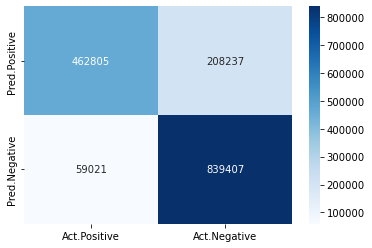

In [28]:
#validate model with validate.data 
Y_validate = data_validate[['churn_2w']]
validation_test = model_xg.predict(X_validate)
# Print the prediction accuracy
print('XGBOOST - VALIDATION DATA RESULT')
print(classification_report(Y_validate, validation_test))
result_validation = pd.DataFrame()
result_validation['churn_2w'] = Y_validate
result_validation['pred_churn'] = validation_test
print('\nTrue Positives(TP)  = ', sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] != 0)))

cf_matrix = np.array([[sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] == 1)), sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] != 1))],
                      [sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] != 0)), sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] == 0))]])
x_axis_labels = ['Act.Positive', 'Act.Negative']
y_axis_labels = ['Pred.Positive', 'Pred.Negative']
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='g') 


XGBOOST - RAW DATA RESULT
              precision    recall  f1-score   support

           0       0.93      0.79      0.85   1039444
           1       0.70      0.89      0.78    569698

    accuracy                           0.83   1609142
   macro avg       0.81      0.84      0.82   1609142
weighted avg       0.85      0.83      0.83   1609142


True Positives(TP)  =  504684

True Negatives(TN)  =  824315

False Positives(FP) =  215129

False Negatives(FN) =  65014


<AxesSubplot:>

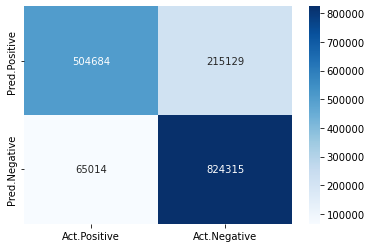

In [29]:
#validate model with raw data 
X_raw = data_ref[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user'
]]

Y_raw = data_ref[['churn_2w']]

raw_test = model_xg.predict(X_raw)
# Print the prediction accuracy
print('XGBOOST - RAW DATA RESULT')
print(classification_report(Y_raw, raw_test))
result_validation = pd.DataFrame()
result_validation['churn_2w'] = Y_raw
result_validation['pred_churn'] = raw_test
print('\nTrue Positives(TP)  = ', sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] != 0)))

cf_matrix = np.array([[sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] == 1)), sum((result_validation['pred_churn'] == 1) & (result_validation['churn_2w'] != 1))],
                      [sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] != 0)), sum((result_validation['pred_churn'] == 0) & (result_validation['churn_2w'] == 0))]])
x_axis_labels = ['Act.Positive', 'Act.Negative']
y_axis_labels = ['Pred.Positive', 'Pred.Negative']
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='g') 

In [31]:
df_segmentation.head()

,browser_id,inactive_days_till_ref,standard_rescaled_inactive_days_till_ref,lad_ref.active_days_last_4w,standard_rescaled_lad_ref.active_days_last_4w,seniority_till_last_active,standard_rescaled_seniority_till_last_active,R,F,S
0,9568155f-a5ac-0a41-03eb-fa751f5151dd.W12Qx9Umm...,11,0.603753,1,-0.987665,394,1.561524,7-14 days not active,<= 7d active,>90d
1,e1b20a76-23b3-e5a5-5164-2d0261a3173d.z4MCm-znN...,11,0.603753,1,-0.987665,116,-0.395682,7-14 days not active,<= 7d active,>90d
2,4cc2fd28-e3ee-4aae-a880-a1e28258796c.iW7T6IiUW...,0,-0.793865,1,-0.987665,0,-1.212357,0-7 days not active,<= 7d active,<= 28d
3,c6367847-7983-3f83-a203-fc49305eb493.0yHHqSf8p...,4,-0.285641,9,-0.175939,394,1.561524,0-7 days not active,>14d,>90d
4,6648e0a2-1464-e712-2828-01d9cb6c3873.2EUD-ByiS...,1,-0.666809,2,-0.886199,8,-1.156035,0-7 days not active,<= 7d active,<= 28d


In [32]:
df_segmentation['pred_churn'] = raw_test
df_segmentation['churn_2w'] = Y_raw
df_segmentation['result_pred'] = np.where((df_segmentation['pred_churn'] == 1) & (df_segmentation['churn_2w'] == 1), 'True Positive',
                                         np.where((df_segmentation['pred_churn'] == 0) & (df_segmentation['churn_2w'] == 0), 'True Negative',
                                                 np.where((df_segmentation['pred_churn'] == 1) & (df_segmentation['churn_2w'] != 1), 'False Positive', 'False Negative')))
df_segmentation.head()

C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\2046419138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segmentation['pred_churn'] = raw_test
C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\2046419138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segmentation['churn_2w'] = Y_raw
C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\2046419138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,browser_id,inactive_days_till_ref,standard_rescaled_inactive_days_till_ref,lad_ref.active_days_last_4w,standard_rescaled_lad_ref.active_days_last_4w,seniority_till_last_active,standard_rescaled_seniority_till_last_active,R,F,S,pred_churn,churn_2w,result_pred
0,9568155f-a5ac-0a41-03eb-fa751f5151dd.W12Qx9Umm...,11,0.603753,1,-0.987665,394,1.561524,7-14 days not active,<= 7d active,>90d,1,1,True Positive
1,e1b20a76-23b3-e5a5-5164-2d0261a3173d.z4MCm-znN...,11,0.603753,1,-0.987665,116,-0.395682,7-14 days not active,<= 7d active,>90d,1,1,True Positive
2,4cc2fd28-e3ee-4aae-a880-a1e28258796c.iW7T6IiUW...,0,-0.793865,1,-0.987665,0,-1.212357,0-7 days not active,<= 7d active,<= 28d,1,0,False Positive
3,c6367847-7983-3f83-a203-fc49305eb493.0yHHqSf8p...,4,-0.285641,9,-0.175939,394,1.561524,0-7 days not active,>14d,>90d,0,0,True Negative
4,6648e0a2-1464-e712-2828-01d9cb6c3873.2EUD-ByiS...,1,-0.666809,2,-0.886199,8,-1.156035,0-7 days not active,<= 7d active,<= 28d,1,1,True Positive


In [33]:
df_segmentation_by_kmean = df_segmentation.assign(tp = np.where(df_segmentation['result_pred'] == 'True Positive', 1, 0)
                      ,tn = np.where(df_segmentation['result_pred'] == 'True Negative', 1, 0)
                      ,fp = np.where(df_segmentation['result_pred'] == 'False Positive', 1, 0)
                      ,fn = np.where(df_segmentation['result_pred'] == 'False Negative', 1, 0)).groupby(['F']).agg({'inactive_days_till_ref': 'mean', 'lad_ref.active_days_last_4w': 'mean', 'seniority_till_last_active': 'mean', 'tp': 'sum', 'tn': 'sum', 'fp': 'sum', 'fn': 'sum', 'browser_id': 'count'})

df_segmentation_by_kmean['%tp'] = df_segmentation_by_kmean['tp'] / df_segmentation_by_kmean['browser_id']
df_segmentation_by_kmean['%tn'] = df_segmentation_by_kmean['tn'] / df_segmentation_by_kmean['browser_id']
df_segmentation_by_kmean['%fp'] = df_segmentation_by_kmean['fp'] / df_segmentation_by_kmean['browser_id']
df_segmentation_by_kmean['%fn'] = df_segmentation_by_kmean['fn'] / df_segmentation_by_kmean['browser_id']
df_segmentation_by_kmean

,inactive_days_till_ref,lad_ref.active_days_last_4w,seniority_till_last_active,tp,tn,fp,fn,browser_id,%tp,%tn,%fp,%fn
F,,,,,,,,,,,,
7-14d active,2.940510,10.358935,10.908250,4254,14513,1409,903,21079,0.201812,0.688505,0.066844,0.042839
<= 7d active,10.657323,2.598293,144.687703,466282,140022,196963,36119,839386,0.555504,0.166815,0.234651,0.043030
>14d,1.397879,19.865938,207.591823,34148,669780,16757,27992,748677,0.045611,0.894618,0.022382,0.037389


In [99]:
df_segmentation.assign(kmean0 = np.where(df_segmentation['kmean_group'] == 0, 1, 0)
                      ,kmean1 = np.where(df_segmentation['kmean_group'] == 1, 1, 0)
                      ,kmean2 = np.where(df_segmentation['kmean_group'] == 2, 1, 0)
                      ,kmean3 = np.where(df_segmentation['kmean_group'] == 3, 1, 0)).groupby(['result_pred']).agg({'inactive_days_till_ref': 'mean', 'lad_ref.active_days_last_4w': 'mean', 'seniority_till_last_active': 'mean', 'kmean0': 'sum', 'kmean1': 'sum', 'kmean2': 'sum', 'kmean3': 'sum', 'browser_id': 'count'}).rename(columns = {'browser_id': 'number of users'})

,inactive_days_till_ref,lad_ref.active_days_last_4w,seniority_till_last_active,kmean0,kmean1,kmean2,kmean3,number of users
result_pred,,,,,,,,
False Negative,2.604090,8.971004,181.812052,34795,20857,8695,6,64353
False Positive,10.164981,3.249871,161.114091,86003,70022,3550,57129,216704
True Negative,0.850799,17.757070,201.353542,226541,126029,470137,33,822740
True Positive,13.819850,2.733726,128.273077,136772,122354,6835,239384,505345


In [41]:
result_analysis = df_segmentation.groupby(['result_pred', 'F', 'S', 'R']).agg({'browser_id': 'count'}).rename(columns = {'browser_id': 'number of users'}).sort_values(by = 'number of users', ascending = False).reset_index()
fp = result_analysis[result_analysis['result_pred'] == 'False Positive']
fp['% users'] = fp['number of users'] / fp['number of users'].sum()
fp

C:\Users\manhdang_coccoc\AppData\Local\Temp\ipykernel_16968\2602539691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp['% users'] = fp['number of users'] / fp['number of users'].sum()


,result_pred,F,S,R,number of users,% users
11,False Positive,<= 7d active,>90d,0-7 days not active,40619,0.188812
12,False Positive,<= 7d active,>90d,7-14 days not active,37946,0.176387
15,False Positive,<= 7d active,<= 28d,0-7 days not active,27920,0.129783
16,False Positive,<= 7d active,>90d,14-21 days not active,22424,0.104235
25,False Positive,<= 7d active,28-90d,0-7 days not active,12677,0.058927
26,False Positive,<= 7d active,>90d,21-28 days not active,12430,0.057779
27,False Positive,<= 7d active,28-90d,7-14 days not active,11530,0.053596
28,False Positive,<= 7d active,<= 28d,7-14 days not active,11250,0.052294
32,False Positive,<= 7d active,28-90d,14-21 days not active,6697,0.031130
33,False Positive,<= 7d active,<= 28d,14-21 days not active,6276,0.029173


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

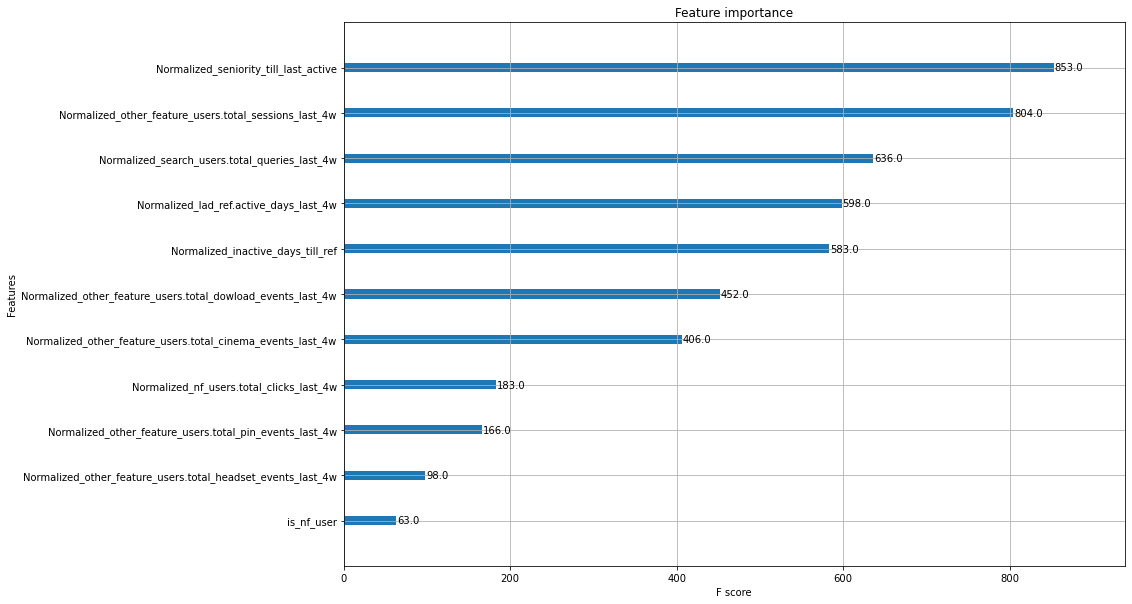

In [15]:
# plot feature importance XGBoost
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (14, 10)
plot_importance(model_xg)

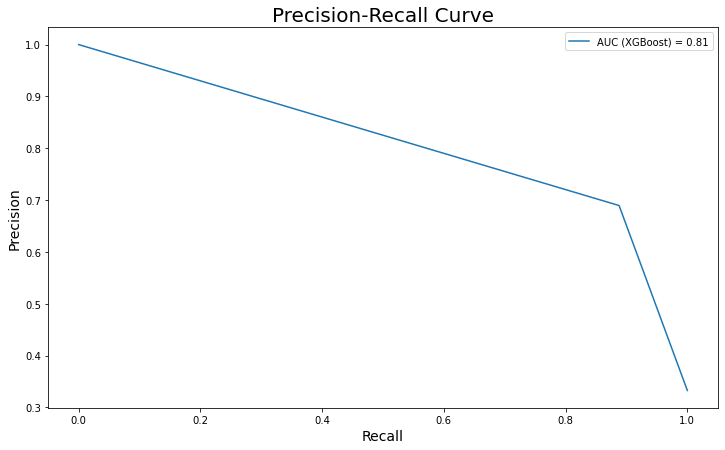

In [18]:
precision_xg, recall_xg, _ = precision_recall_curve(Y_validate, validation_test)
auc_xg = auc(recall_xg, precision_xg)
plt.figure(figsize=(12, 7))
plt.plot(recall_xg, precision_xg, label=f'AUC (XGBoost) = {auc_xg:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend()

C:\Users\manhdang\AppData\Local\Temp\ipykernel_2252\2396972117.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


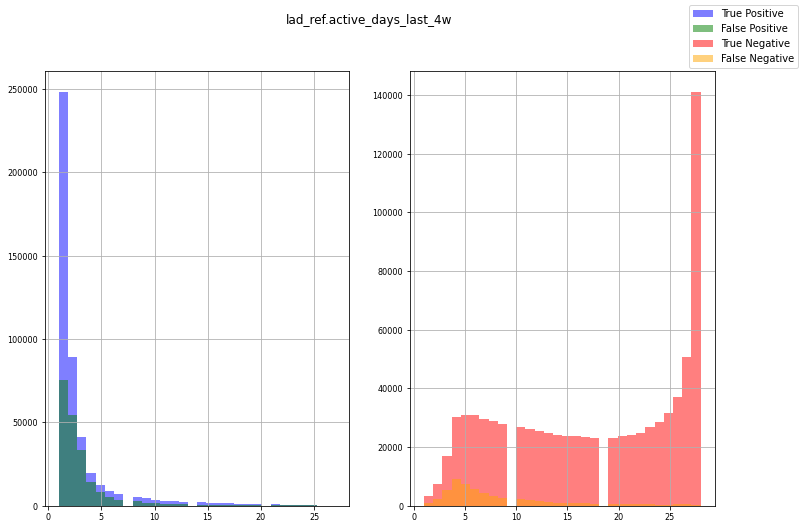

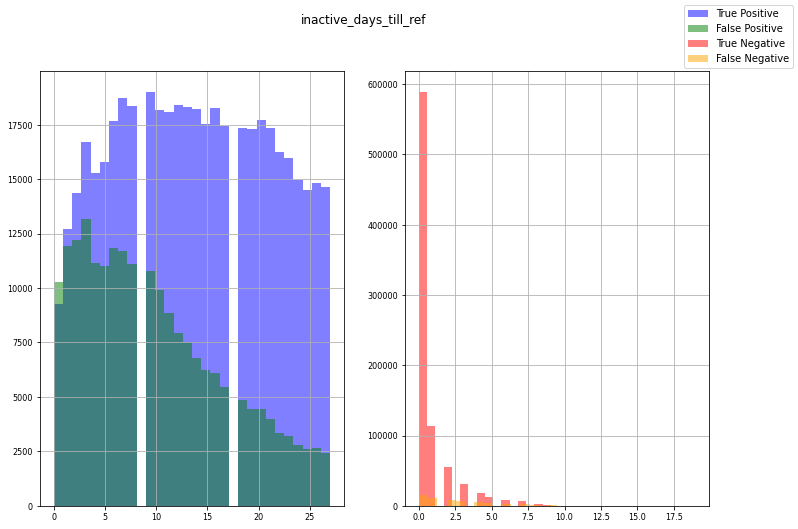

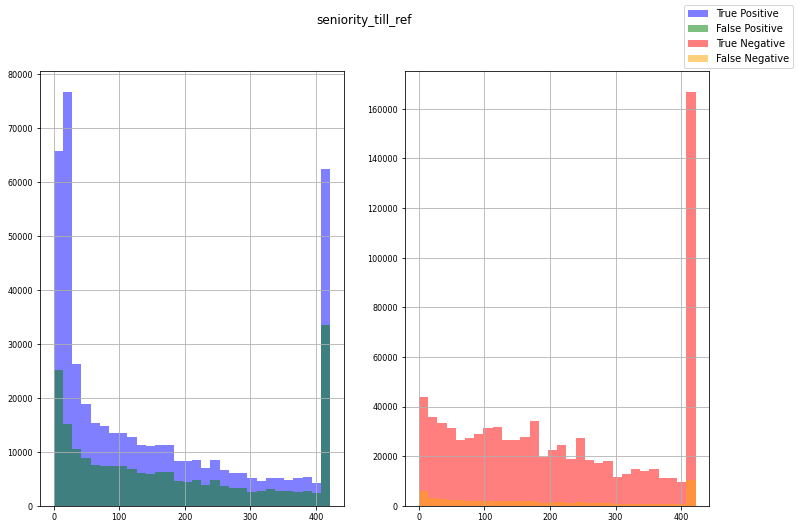

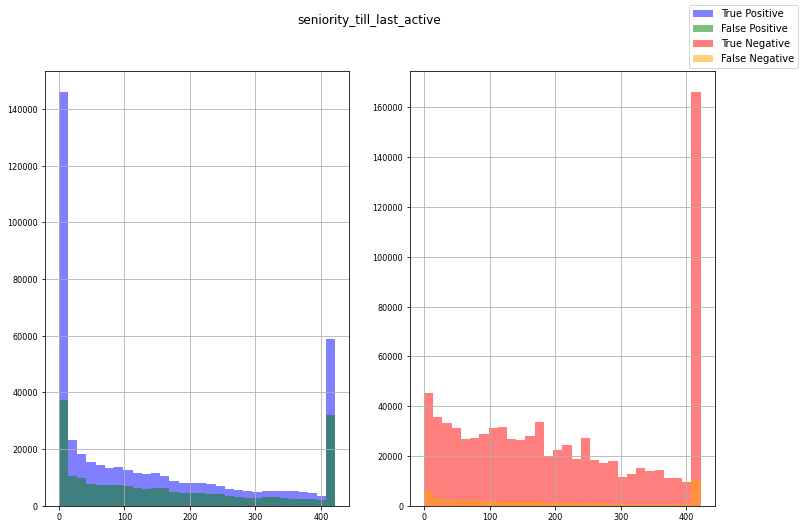

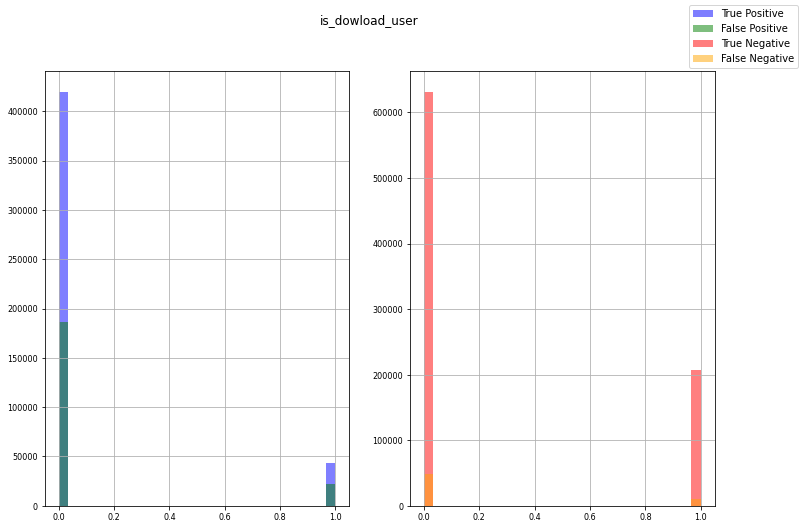

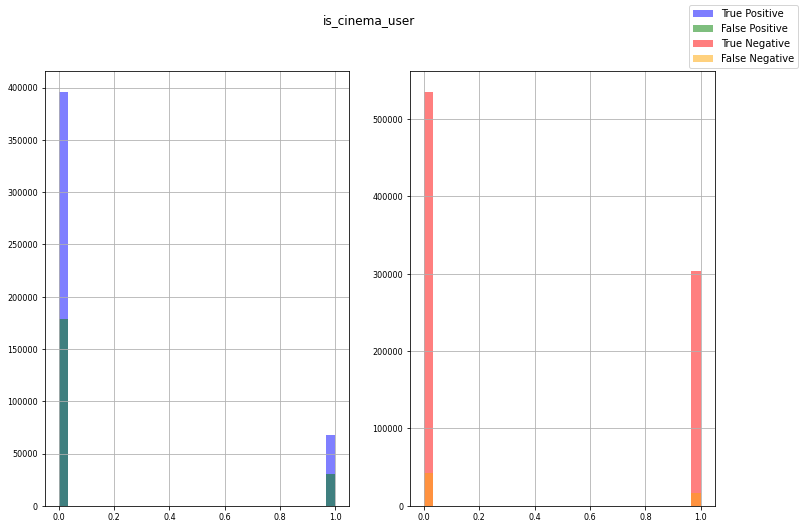

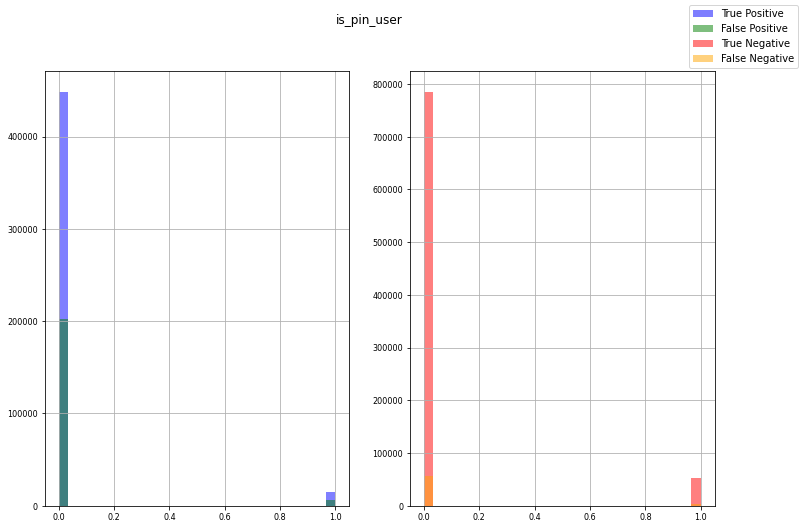

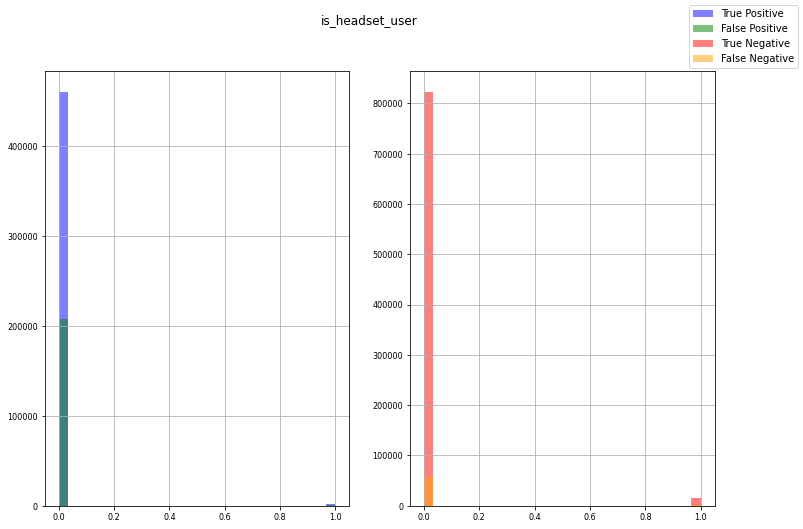

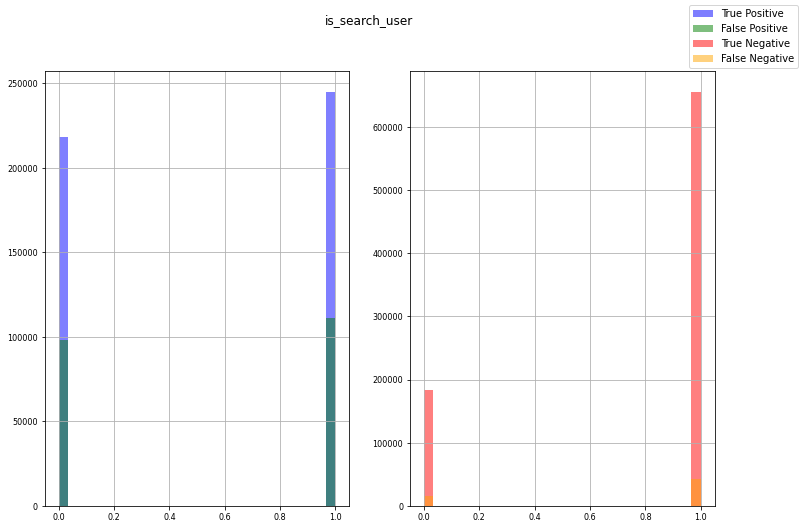

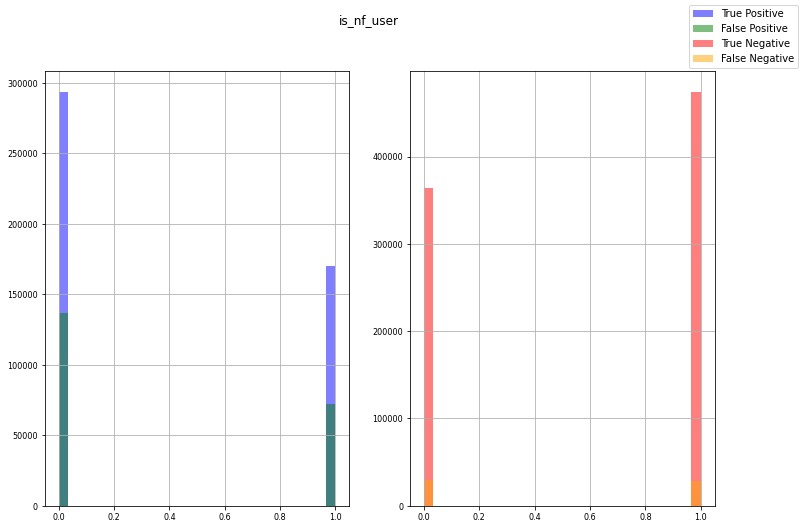

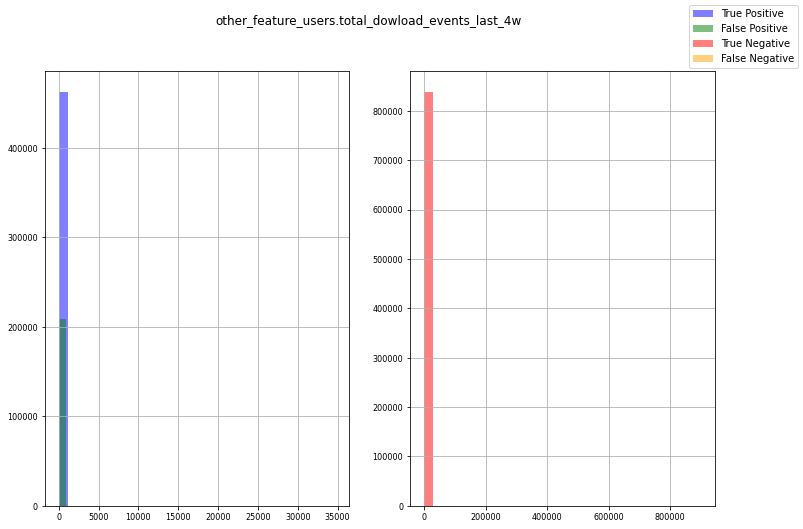

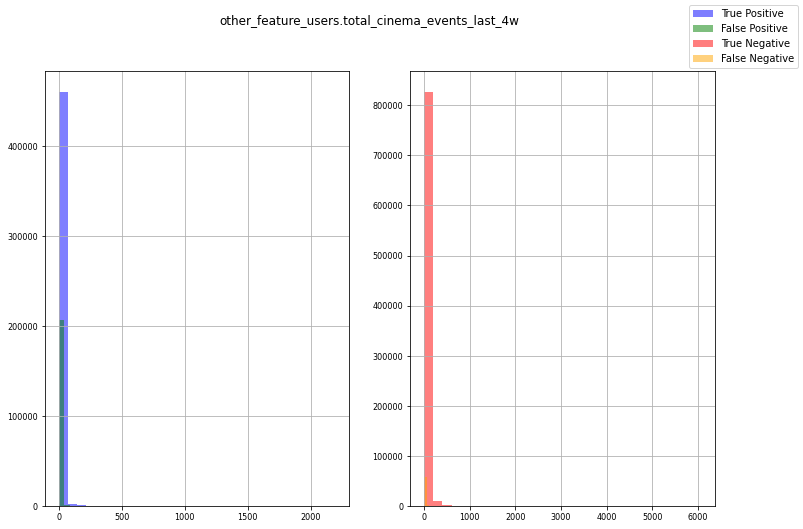

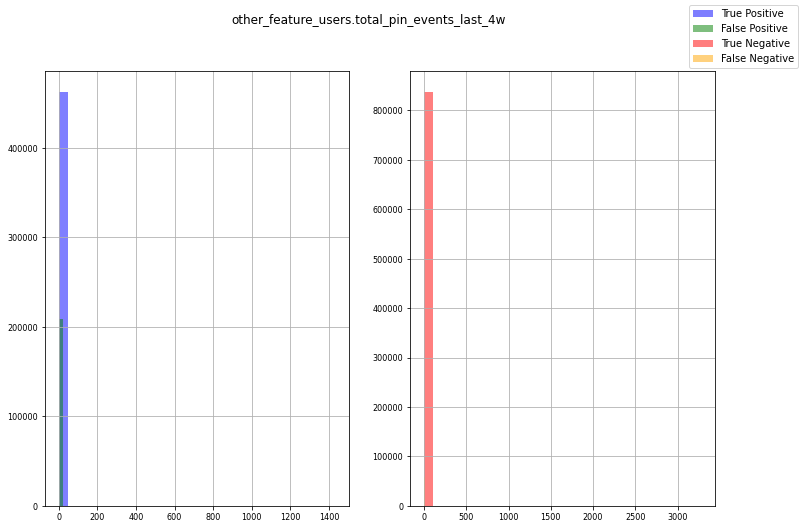

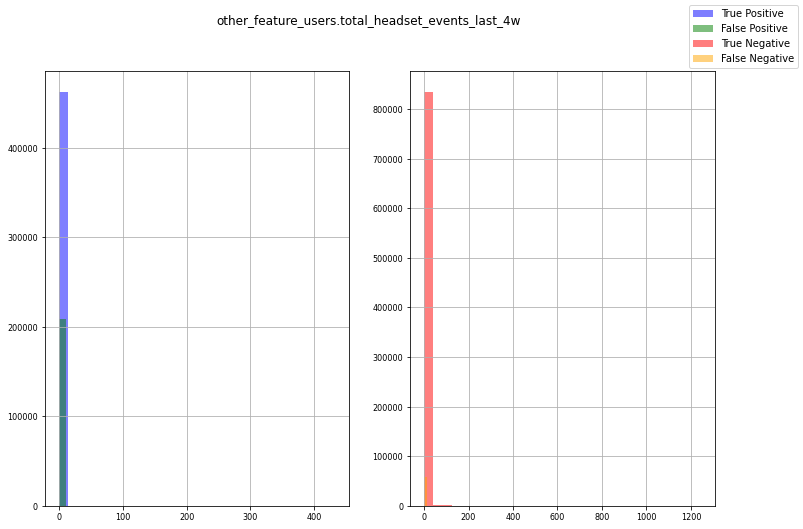

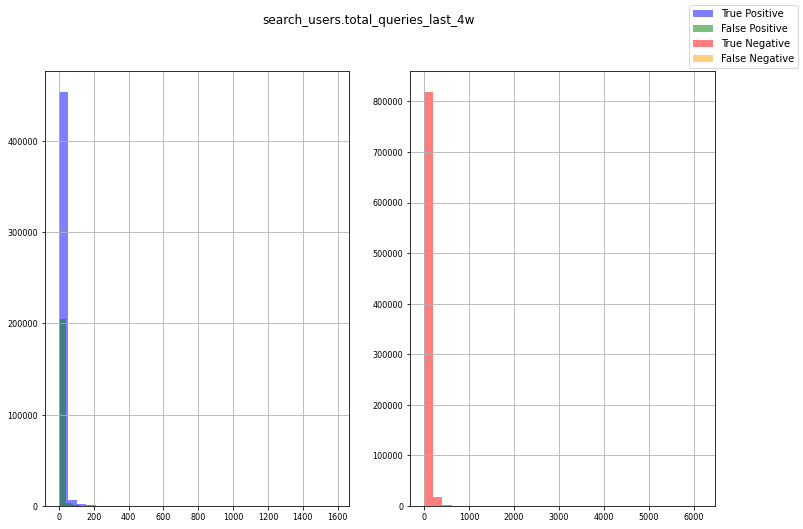

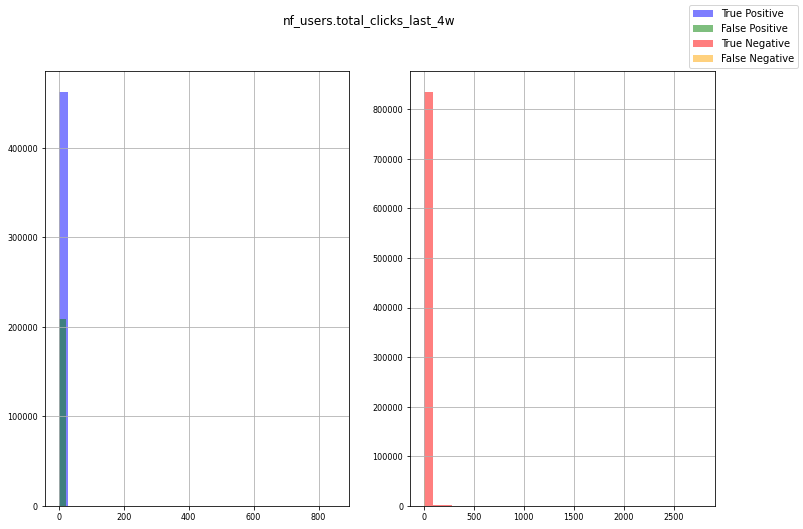

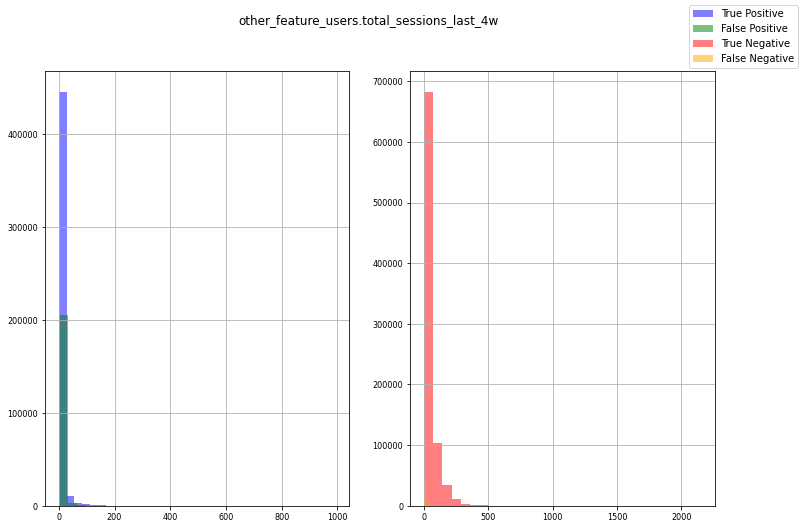

In [24]:
df_final_27feb['pred_churn'] = validation_test
for i in df_final_27feb.columns[9:26]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    df_final_27feb[i][(df_final_27feb['pred_churn'] == 1) & (df_final_27feb['churn_2w'] == 1)].hist(label = 'True Positive', figsize = (12, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'blue', alpha = 0.5, ax = ax1)
    df_final_27feb[i][(df_final_27feb['pred_churn'] == 1) & (df_final_27feb['churn_2w'] != 1)].hist(label = 'False Positive', figsize = (12, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'green', alpha = 0.5, ax = ax1)
    df_final_27feb[i][(df_final_27feb['pred_churn'] == 0) & (df_final_27feb['churn_2w'] == 0)].hist(label = 'True Negative', figsize = (12, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'red', alpha = 0.5, ax = ax2)
    df_final_27feb[i][(df_final_27feb['pred_churn'] == 0) & (df_final_27feb['churn_2w'] != 0)].hist(label = 'False Negative', figsize = (12, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'orange', alpha = 0.5, ax = ax2)
    fig.legend()
    fig.suptitle(i)
    fig.show()

C:\Users\manhdang\AppData\Local\Temp\ipykernel_1956\2032243432.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_downsampled = X_yes.append(X_no_downsampled).reset_index(drop=True)
C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


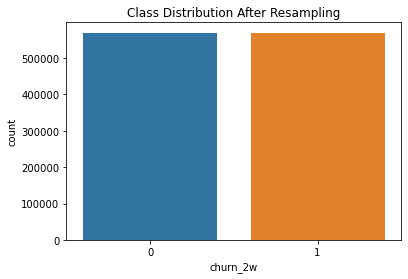

In [14]:
#Separating positive class (churn=1) and negative class (churn=0)
X_no = data_ref[data_ref['churn_2w'] == 0]
X_yes = data_ref[data_ref['churn_2w'] == 1]

#Downsampling the positive class
X_no_downsampled = X_no.sample(n=len(X_yes), replace=True, random_state=42)

#Combining positive and negative class and checking class distribution
X_downsampled = X_yes.append(X_no_downsampled).reset_index(drop=True)
sns.countplot('churn_2w', data=X_downsampled).set_title('Class Distribution After Resampling')

# Create Train & Test Data with downsampled data of X_no
X_ref = X_downsampled.drop(['churn_2w'], axis=1) #features (independent variables)
Y_ref = X_downsampled['churn_2w'] #target (dependent variable)

X_train, X_test, Y_train, Y_test = train_test_split(X_ref, Y_ref, test_size=0.2, random_state=42)

In [15]:
#XGBClassifier
model_xg = XGBClassifier()
result = model_xg.fit(X_train, Y_train)
prediction_test = model_xg.predict(X_test)
# Print the prediction accuracy
print('REF DATA RESULT')
print(classification_report(Y_test, prediction_test))
print('---------------------------------------------------')
print('---------------------------------------------------')
print('---------------------------------------------------')
#validate model with validate.data 
Y_validate = data_validate[['churn_2w']]
validation_test = model_xg.predict(X_validate)
data_validate['pred_churn'] = validation_test
# Print the prediction accuracy
print('VALIDATION DATA RESULT')
print(classification_report(Y_validate, validation_test))
data_validate['pred_churn'] = validation_test
print('\nTrue Positives(TP)  = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] != 0)))

C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:04:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
REF DATA RESULT
              precision    recall  f1-score   support

           0       0.87      0.79      0.83    113889
           1       0.81      0.89      0.85    113991

    accuracy                           0.84    227880
   macro avg       0.84      0.84      0.84    227880
weighted avg       0.84      0.84      0.84    227880

---------------------------------------------------
---------------------------------------------------
---------------------------------------------------


C:\Users\manhdang\AppData\Local\Temp\ipykernel_1956\2090929545.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_validate['pred_churn'] = validation_test


VALIDATION DATA RESULT
              precision    recall  f1-score   support

           0       0.93      0.80      0.86   1047644
           1       0.69      0.89      0.78    521826

    accuracy                           0.83   1569470
   macro avg       0.81      0.84      0.82   1569470
weighted avg       0.85      0.83      0.83   1569470


True Positives(TP)  =  463437


C:\Users\manhdang\AppData\Local\Temp\ipykernel_1956\2090929545.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_validate['pred_churn'] = validation_test



True Negatives(TN)  =  838067

False Positives(FP) =  209577

False Negatives(FN) =  58389


In [16]:
#no resampling data
X_ref = data_ref[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user'
]]

Y_ref = data_ref[['churn_2w']]
X_train, X_test, Y_train, Y_test = train_test_split(X_ref, Y_ref, test_size=0.2, stratify = Y_ref)

In [22]:
#XGBClassifier with scale post weight
model_xg = XGBClassifier(scale_pos_weight = sum(Y_train['churn_2w'] == 0) / sum(Y_train['churn_2w'] == 1))
result = model_xg.fit(X_train, Y_train)
prediction_test = model_xg.predict(X_test)
# Print the prediction accuracy
print('REF DATA RESULT')
print(classification_report(Y_test, prediction_test))
print('---------------------------------------------------')
print('---------------------------------------------------')
print('---------------------------------------------------')
#validate model with validate.data 
Y_validate = data_validate[['churn_2w']]
validation_test = model_xg.predict(X_validate)
data_validate['pred_churn'] = validation_test
# Print the prediction accuracy
print('VALIDATION DATA RESULT')
print(classification_report(Y_validate, validation_test))
data_validate['pred_churn'] = validation_test
print('\nTrue Positives(TP)  = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] != 0)))

C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\manhdang\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\manhdang\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15:25:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
REF DATA RESULT
              precision    recall  f1-score   support

           0       0.93      0.79      0.85    207889
           1       0.70      0.89      0.78    113940

    accuracy                           0.83    321829
   macro avg       0.81      0.84      0.82    321829
weighted avg       0.85      0.83      0.83    321829

---------------------------------------------------
---------------------------------------------------
---------------------------------------------------


C:\Users\manhdang\AppData\Local\Temp\ipykernel_1956\4080910572.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_validate['pred_churn'] = validation_test


VALIDATION DATA RESULT
              precision    recall  f1-score   support

           0       0.94      0.80      0.86   1047644
           1       0.69      0.89      0.78    521826

    accuracy                           0.83   1569470
   macro avg       0.81      0.84      0.82   1569470
weighted avg       0.85      0.83      0.83   1569470


True Positives(TP)  =  463835


C:\Users\manhdang\AppData\Local\Temp\ipykernel_1956\4080910572.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_validate['pred_churn'] = validation_test



True Negatives(TN)  =  837693

False Positives(FP) =  209951

False Negatives(FN) =  57991


In [26]:
#get all positive prediction and try to classify again from these data
df_list = [df_final_30jan, df_final_27feb, df_final_27mar, df_final_24apr]
data_ref = pd.concat(df_list, ignore_index = True)[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user',
#Target
        'churn_2w']]

X_ref = data_ref[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user']]

Y_ref = data_ref[['churn_2w']]

In [29]:
#predict with model ref.date = 30jan for data 30jan - 24apr
prediction_test = model_xg.predict(X_ref)
data_ref['pred_churn'] = prediction_test
# Print the prediction accuracy
print('RESULT WITH MODEL REF.DATE = 30JAN')
print(classification_report(Y_ref, prediction_test))
print('\nTrue Positives(TP)  = ', sum((data_ref['pred_churn'] == 1) & (data_ref['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((data_ref['pred_churn'] == 0) & (data_ref['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((data_ref['pred_churn'] == 1) & (data_ref['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((data_ref['pred_churn'] == 0) & (data_ref['churn_2w'] != 0)))

RESULT WITH MODEL REF.DATE = 30JAN
              precision    recall  f1-score   support

           0       0.93      0.80      0.86   4137629
           1       0.69      0.89      0.78   2101955

    accuracy                           0.83   6239584
   macro avg       0.81      0.84      0.82   6239584
weighted avg       0.85      0.83      0.83   6239584


True Positives(TP)  =  1863653

True Negatives(TN)  =  3312511

False Positives(FP) =  825118

False Negatives(FN) =  238302


In [31]:
#get all positive prediction and construct 2nd model to classify again from these data
X_2nd = data_ref[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user']][data_ref['pred_churn'] == 1]

Y_2nd = data_ref[['churn_2w']][data_ref['pred_churn'] == 1]


,churn_2w
0,1
1,1
2,0
4,1
10,1
...,...
6239577,0
6239578,1
6239579,1
6239580,1


In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X_2nd, Y_2nd, test_size=0.2, stratify = Y_2nd)
#XGBClassifier with scale post weight
model_xg_2nd = XGBClassifier(scale_pos_weight = sum(Y_train['churn_2w'] == 0) / sum(Y_train['churn_2w'] == 1))
result_2nd = model_xg_2nd.fit(X_train, Y_train)
prediction_test = model_xg_2nd.predict(X_test)
# Print the prediction accuracy
print('REF DATA RESULT')
print(classification_report(Y_test, prediction_test))
print('---------------------------------------------------')
print('---------------------------------------------------')
print('---------------------------------------------------')

C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\manhdang\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\manhdang\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[16:02:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
REF DATA RESULT
              precision    recall  f1-score   support

           0       0.46      0.65      0.54    165024
           1       0.81      0.67      0.73    372731

    accuracy                           0.66    537755
   macro avg       0.64      0.66      0.64    537755
weighted avg       0.71      0.66      0.67    537755

---------------------------------------------------
---------------------------------------------------
---------------------------------------------------


In [47]:
df_final_27feb[['browser_id', 'seniority_till_last_active', 'lad_2w_past_ref.last_active_date', 'first_active_date', 'lad_current.last_active_date']][df_final_27feb['seniority_till_last_active'] == 0]

,browser_id,seniority_till_last_active,lad_2w_past_ref.last_active_date,first_active_date,lad_current.last_active_date
36,dee07188-f4d8-24bb-4286-b847e7065efb.qMzZG0Xkz...,0,2022-02-19,2022-02-19,2022-02-19
89,12e8c9de-d63b-cf51-94d1-740e7014a1cf.zYdYF5lsA...,0,2022-03-03,2022-02-15,2022-03-17
149,5b571b10-24f9-7471-d5c0-353aadec72bc.S5H_UKXiN...,0,2022-02-15,2022-02-15,2022-02-15
161,818b7b82-15f7-2863-4560-d2e128f7714f.mOGw7AHyi...,0,2022-02-07,2022-02-07,2022-02-07
164,1b210ad8-d34e-7f84-e7a5-e47f53419d83.CwheQADvX...,0,2022-02-02,2022-02-02,2022-02-02
...,...,...,...,...,...
1569417,f5b04f98-e60a-739a-4abd-2e558181bbcf.qCZpna46c...,0,2022-02-21,2022-02-21,2022-02-21
1569435,40f1816f-bc56-2bc4-1b34-bf1000cad7c6.-XeXgft2W...,0,2022-03-13,2022-02-26,2022-04-15
1569438,a12861f7-043d-d967-6268-91ec9458e0e2.UtJJrM98J...,0,2022-03-13,2022-02-08,2022-06-20
1569445,50eca33e-f445-d7c4-2817-e5b5c71d7b3e.95cfY9-fm...,0,2022-03-12,2022-02-27,2022-09-17


C:\Users\manhdang\AppData\Local\Temp\ipykernel_4300\3514419460.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


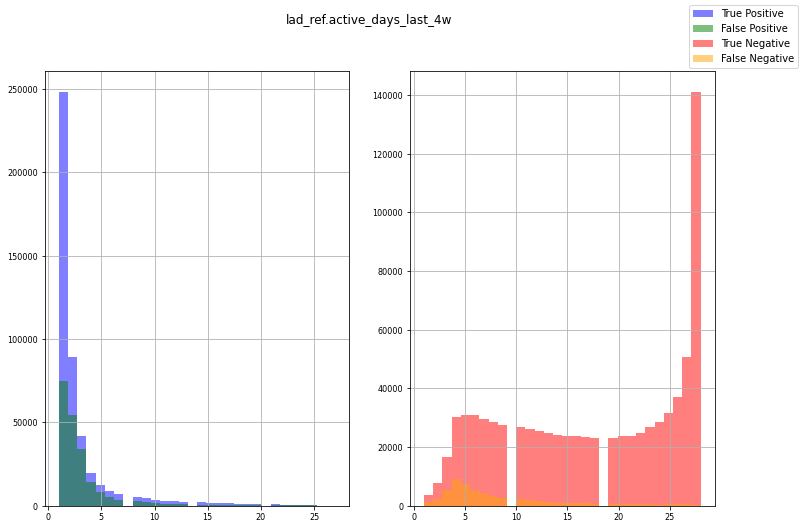

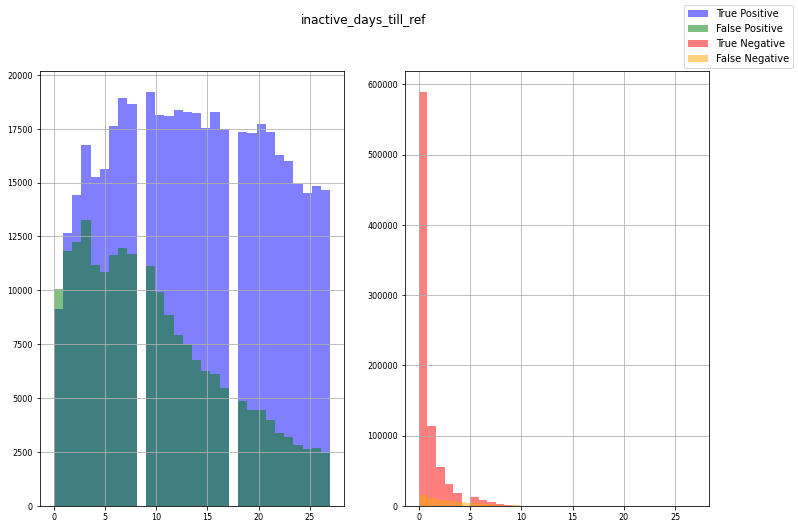

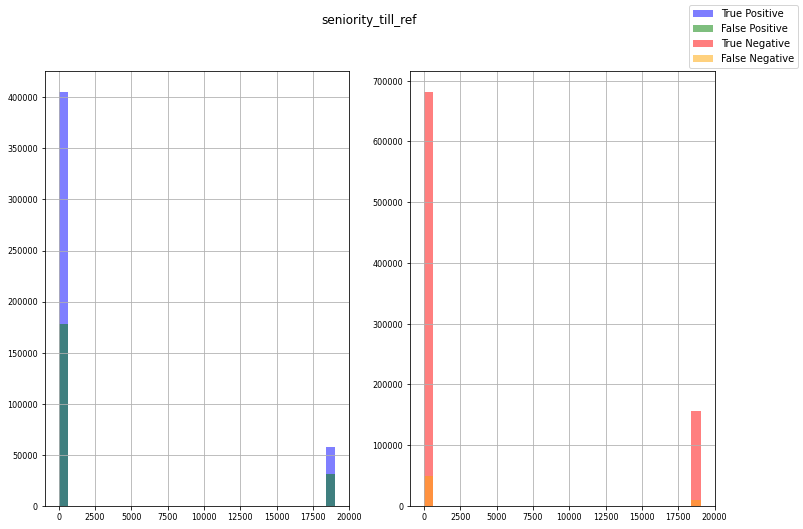

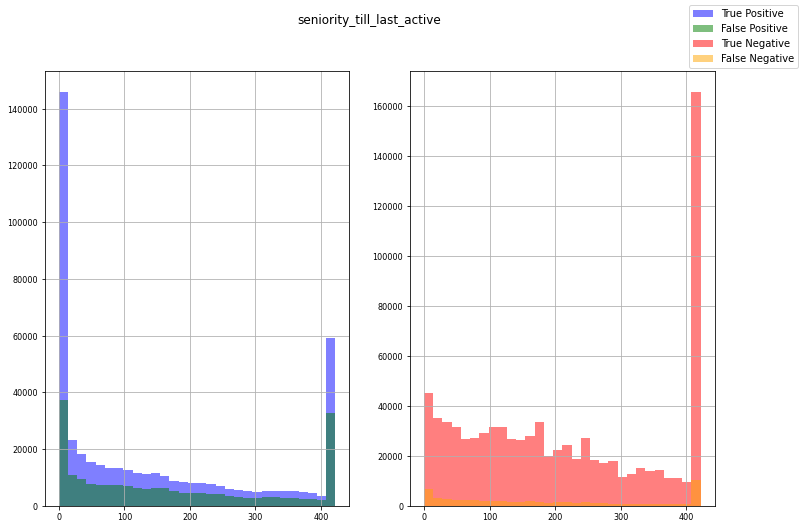

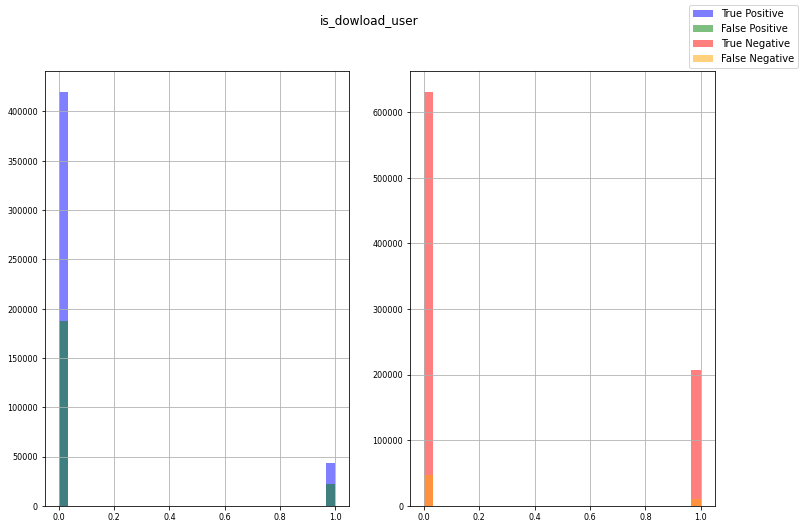

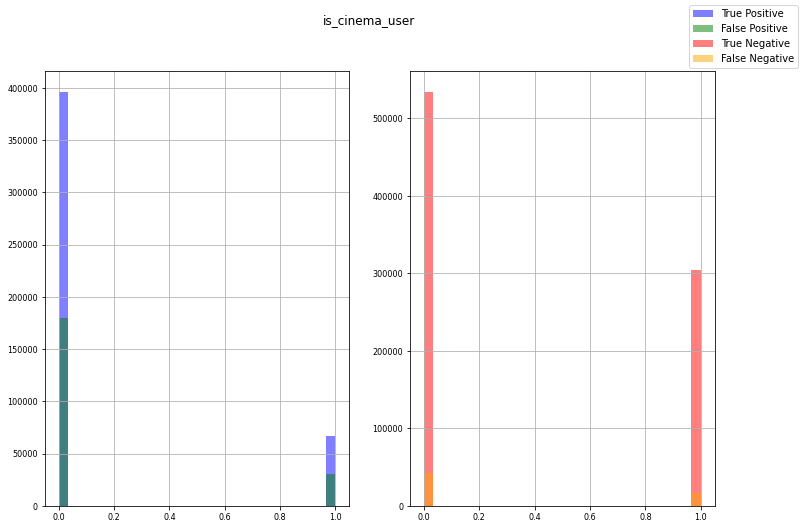

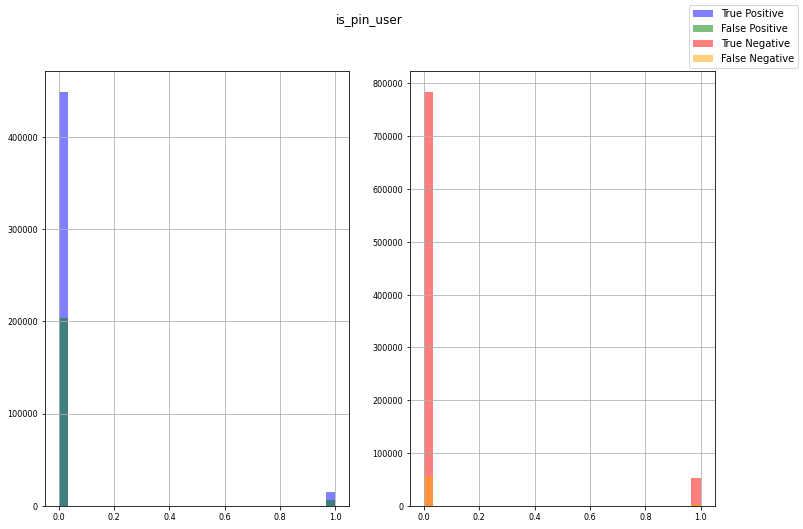

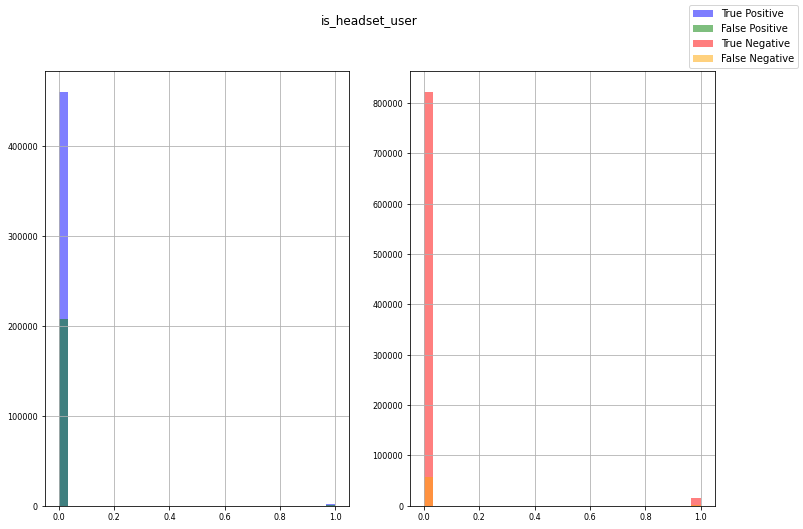

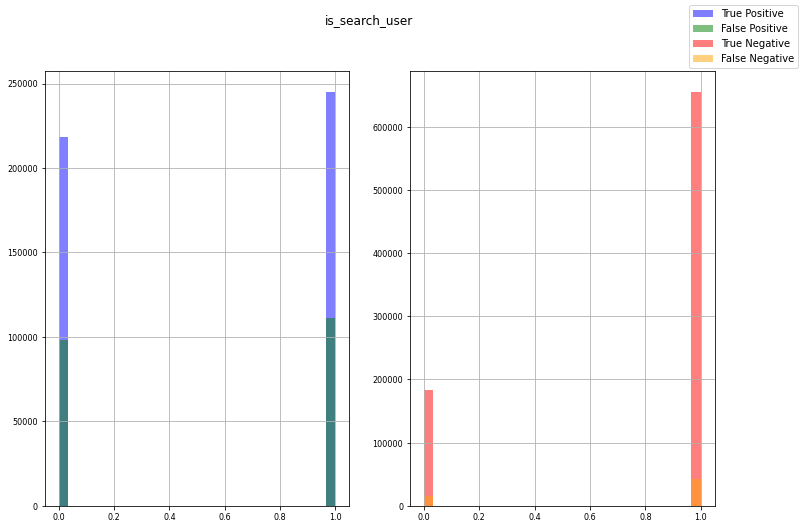

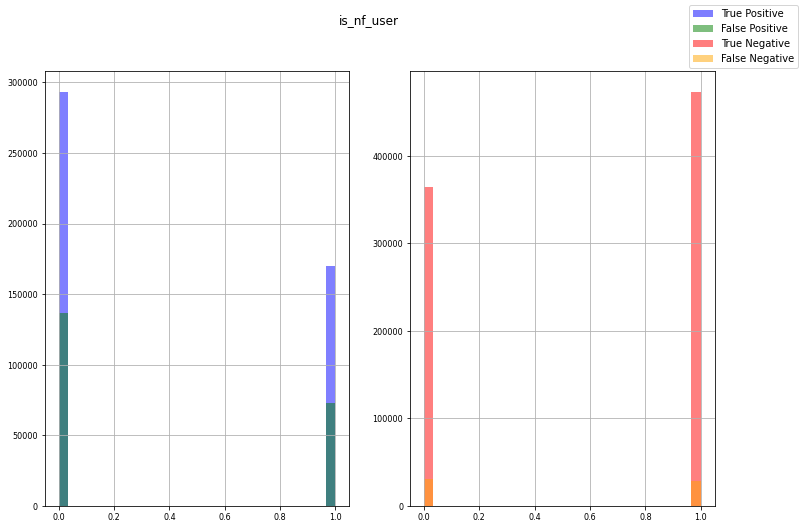

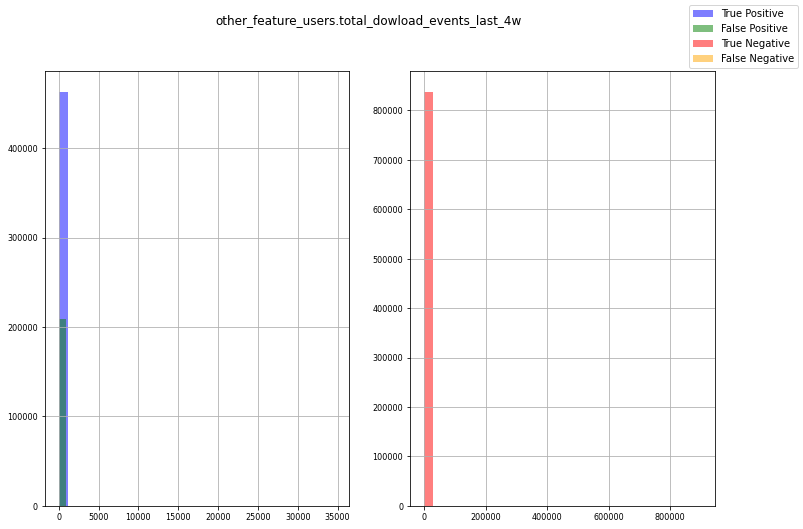

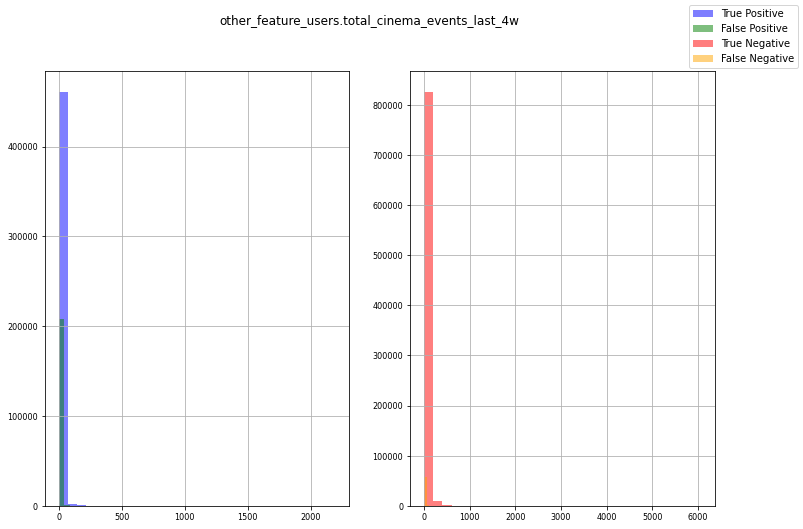

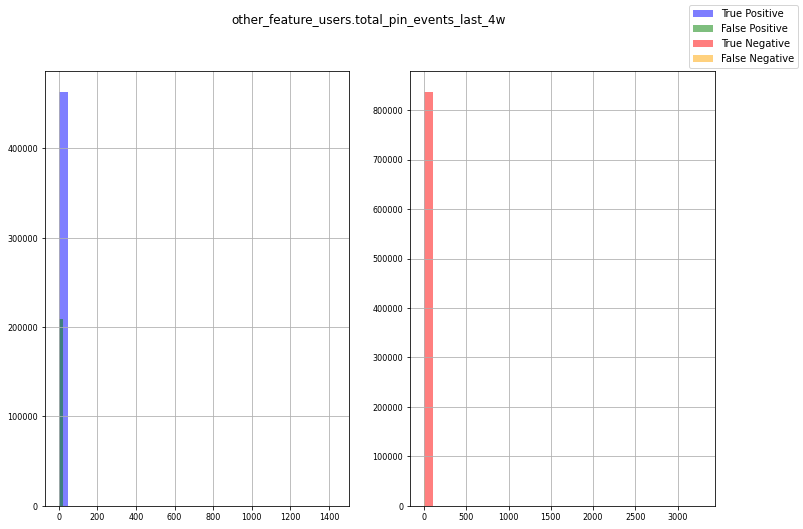

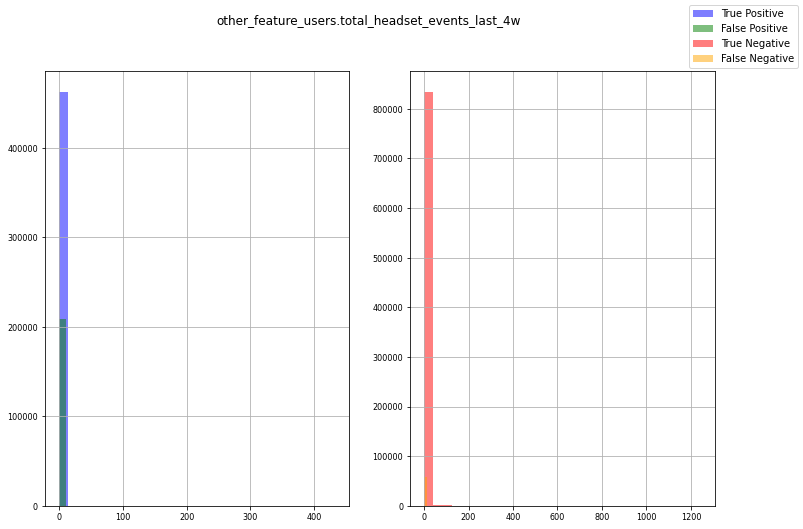

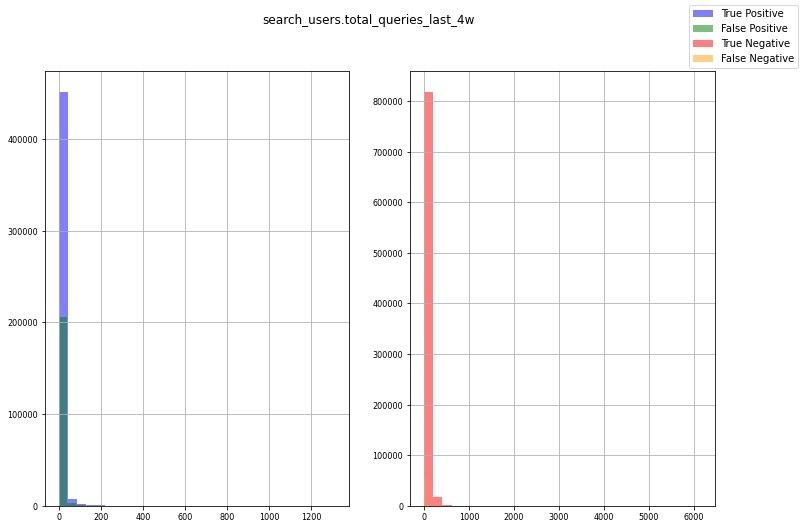

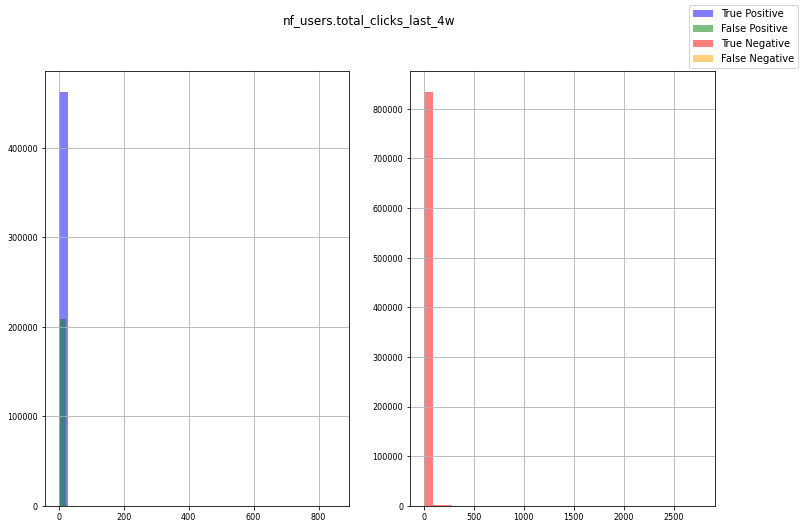

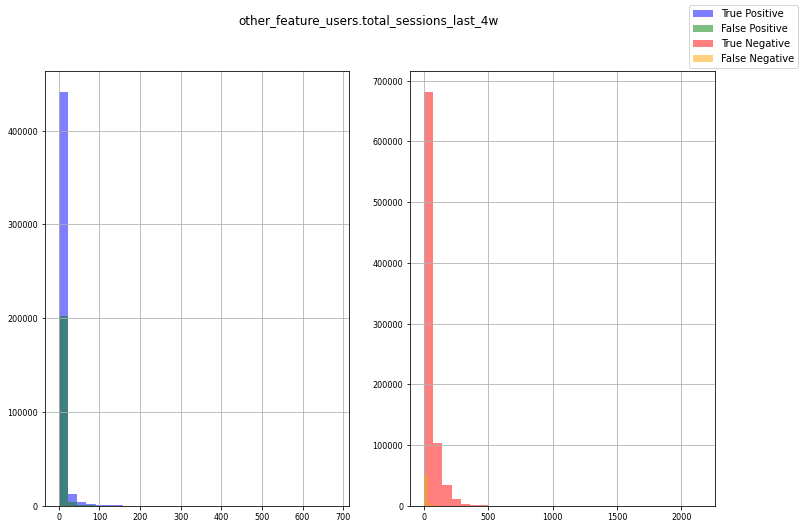

In [23]:
for i in df_final_27feb.columns[9:26]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    df_final_27feb[i][(df_final_27feb['pred_churn'] == 1) & (df_final_27feb['churn_2w'] == 1)].hist(label = 'True Positive', figsize = (12, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'blue', alpha = 0.5, ax = ax1)
    df_final_27feb[i][(df_final_27feb['pred_churn'] == 1) & (df_final_27feb['churn_2w'] != 1)].hist(label = 'False Positive', figsize = (12, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'green', alpha = 0.5, ax = ax1)
    df_final_27feb[i][(df_final_27feb['pred_churn'] == 0) & (df_final_27feb['churn_2w'] == 0)].hist(label = 'True Negative', figsize = (12, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'red', alpha = 0.5, ax = ax2)
    df_final_27feb[i][(df_final_27feb['pred_churn'] == 0) & (df_final_27feb['churn_2w'] != 0)].hist(label = 'False Negative', figsize = (12, 8), bins=30, xlabelsize=8, ylabelsize=8, color = 'orange', alpha = 0.5, ax = ax2)
    fig.legend()
    fig.suptitle(i)
    fig.show()


In [27]:
print('-----------Finish training with data 30 jan---------')

-----------Finish training with data 30 jan---------


C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


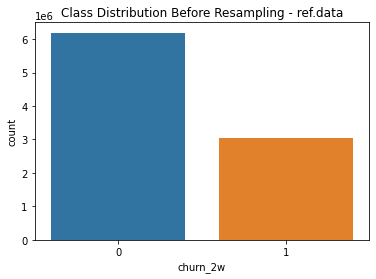

C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


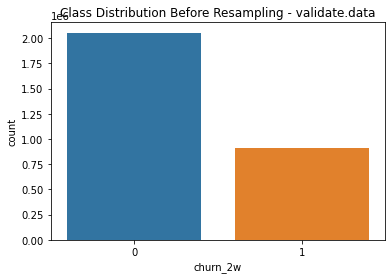

In [30]:
#train model with ref.data =  27feb 30jan, 27feb, 27mar, 24apr, 22may, 19jun and validate.data = 17jul, 14aug
df_ref = [df_final_30jan, df_final_27feb, df_final_27mar, df_final_24apr, df_final_22may, df_final_19jun]
df_validate = [df_final_17jul, df_final_14aug]
data_ref = pd.concat(df_ref, ignore_index = True)[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user',
#Target
        'churn_2w']]

#using data_validate to validate model 
data_validate = pd.concat(df_validate, ignore_index = True)[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user',
#Target
        'churn_2w']]

X_validate = data_validate[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user'
]]

Y_validate = data_validate[['churn_2w']]

#Class Distribution of Unsampled ref.data data
sns.countplot('churn_2w', data=data_ref).set_title('Class Distribution Before Resampling - ref.data')
plt.show()
sns.countplot('churn_2w', data=data_validate).set_title('Class Distribution Before Resampling - validate.data')
plt.show()

C:\Users\manhdang\AppData\Local\Temp\ipykernel_4300\2585313285.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution After Resampling')

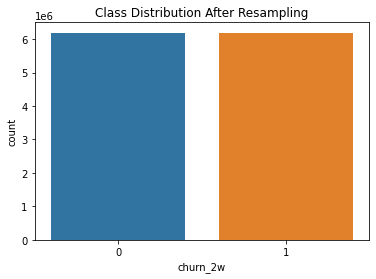

In [31]:
#Separating positive class (churn=1) and negative class (churn=0)
X_no = data_ref[data_ref['churn_2w'] == 0]
X_yes = data_ref[data_ref['churn_2w'] == 1]

#Upsampling the positive class
X_yes_upsampled = X_yes.sample(n=len(X_no), replace=True, random_state=42)

#Combining positive and negative class and checking class distribution
X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
sns.countplot('churn_2w', data=X_upsampled).set_title('Class Distribution After Resampling')

In [44]:
# Create Train & Test Data with resampled data
X_ref = X_upsampled.drop(['churn_2w'], axis=1) #features (independent variables)
Y_ref = X_upsampled['churn_2w'] #target (dependent variable)

X_train, X_test, Y_train, Y_test = train_test_split(X_ref, Y_ref, test_size=0.2, random_state=42)

In [45]:
#Logistic Regression
model_lr = LogisticRegression()
result = model_lr.fit(X_train, Y_train)
prediction_test = model_lr.predict(X_test)
# Print the prediction accuracy
print('REF DATA RESULT')
print(classification_report(Y_test, prediction_test))
print('---------------------------------------------------')
print('---------------------------------------------------')
print('---------------------------------------------------')
#validate model with validate.data 
Y_validate = data_validate[['churn_2w']]
validation_test = model_lr.predict(X_validate)
# Print the prediction accuracy
print('VALIDATION DATA RESULT')
print(classification_report(Y_validate, validation_test))
data_validate['pred_churn'] = validation_test
print('\nTrue Positives(TP)  = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] != 0)))

MemoryError: Unable to allocate 1.18 GiB for an array with shape (9900862, 16) and data type float64

In [34]:
#XGBClassifier
model_xg = XGBClassifier()
result = model_xg.fit(X_train, Y_train)
prediction_test = model_xg.predict(X_test)
# Print the prediction accuracy
print('REF DATA RESULT')
print(classification_report(Y_test, prediction_test))
print('---------------------------------------------------')
print('---------------------------------------------------')
print('---------------------------------------------------')
#validate model with validate.data 
Y_validate = data_validate[['churn_2w']]
validation_test = model_xg.predict(X_validate)
data_validate['pred_churn'] = validation_test
# Print the prediction accuracy
print('VALIDATION DATA RESULT')
print(classification_report(Y_validate, validation_test))
data_validate['pred_churn'] = validation_test
print('\nTrue Positives(TP)  = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] != 0)))

C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:31:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
REF DATA RESULT
              precision    recall  f1-score   support

           0       0.88      0.80      0.84   1237304
           1       0.82      0.89      0.85   1237912

    accuracy                           0.85   2475216
   macro avg       0.85      0.85      0.85   2475216
weighted avg       0.85      0.85      0.85   2475216

---------------------------------------------------
---------------------------------------------------
---------------------------------------------------
VALIDATION DATA RESULT
              precision    recall  f1-score   support

           0       0.93      0.81      0.87   2054408
           1       0.67      0.87      0.76    908893

    accuracy                           0.83   2963301
   macro

In [38]:
# Create Train & Test Data with normal data
X_ref = data_ref[[
#Engagement
    'minmax_rescaled_lad_ref.active_days_last_4w',
       'minmax_rescaled_inactive_days_till_ref',
       'minmax_rescaled_other_feature_users.total_dowload_events_last_4w',
       'minmax_rescaled_other_feature_users.total_cinema_events_last_4w',
       'minmax_rescaled_other_feature_users.total_pin_events_last_4w',
       'minmax_rescaled_other_feature_users.total_headset_events_last_4w',
       'minmax_rescaled_search_users.total_queries_last_4w',
       'minmax_rescaled_nf_users.total_clicks_last_4w',
       'minmax_rescaled_other_feature_users.total_sessions_last_4w',
#Features
       'minmax_rescaled_seniority_till_last_active',
    'is_dowload_user', 'is_cinema_user', 'is_pin_user', 'is_headset_user', 'is_search_user', 'is_nf_user']]

Y_ref = data_ref['churn_2w']
X_train, X_test, Y_train, Y_test = train_test_split(X_ref, Y_ref, test_size=0.2, random_state=42, stratify = Y_ref)

In [39]:
#Logistic Regression
model_lr = LogisticRegression()
result = model_lr.fit(X_train, Y_train)
prediction_test = model_lr.predict(X_test)
# Print the prediction accuracy
print('REF DATA RESULT')
print(classification_report(Y_test, prediction_test))
print('---------------------------------------------------')
print('---------------------------------------------------')
print('---------------------------------------------------')
#validate model with validate.data 
Y_validate = data_validate[['churn_2w']]
validation_test = model_lr.predict(X_validate)
# Print the prediction accuracy
print('VALIDATION DATA RESULT')
print(classification_report(Y_validate, validation_test))
data_validate['pred_churn'] = validation_test
print('\nTrue Positives(TP)  = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] != 0)))

REF DATA RESULT
              precision    recall  f1-score   support

           0       0.85      0.89      0.87   1237608
           1       0.75      0.68      0.71    607049

    accuracy                           0.82   1844657
   macro avg       0.80      0.78      0.79   1844657
weighted avg       0.82      0.82      0.82   1844657

---------------------------------------------------
---------------------------------------------------
---------------------------------------------------
VALIDATION DATA RESULT
              precision    recall  f1-score   support

           0       0.85      0.91      0.88   2054408
           1       0.76      0.64      0.69    908893

    accuracy                           0.83   2963301
   macro avg       0.81      0.77      0.79   2963301
weighted avg       0.82      0.83      0.82   2963301


True Positives(TP)  =  580730

True Negatives(TN)  =  1871546

False Positives(FP) =  182862

False Negatives(FN) =  328163


In [ ]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_resampled, Y_resampled = oversample.fit_resample(X_train, Y_train)

In [ ]:
model_lr = LogisticRegression()
result = model_lr.fit(X_resampled, Y_resampled)
prediction_test = model_lr.predict(X_test)
# Print the prediction accuracy
print('REF DATA RESULT')
print(classification_report(Y_test, prediction_test))
print('---------------------------------------------------')
print('---------------------------------------------------')
print('---------------------------------------------------')
#validate model with validate.data 
Y_validate = data_validate[['churn_2w']]
validation_test = model_lr.predict(X_validate)
# Print the prediction accuracy
print('VALIDATION DATA RESULT')
print(classification_report(Y_validate, validation_test))
data_validate['pred_churn'] = validation_test
print('\nTrue Positives(TP)  = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] == 1)))
print('\nTrue Negatives(TN)  = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] == 0)))
print('\nFalse Positives(FP) = ', sum((data_validate['pred_churn'] == 1) & (data_validate['churn_2w'] != 1)))
print('\nFalse Negatives(FN) = ', sum((data_validate['pred_churn'] == 0) & (data_validate['churn_2w'] != 0)))

In [70]:
#XGBClassifier
model_xg = XGBClassifier()
result = model_xg.fit(X_train, Y_train)
prediction_test = model_xg.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(Y_test, prediction_test))

C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:01:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8288252457050173


In [71]:
cm = confusion_matrix(Y_test, prediction_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[199156  28765]
 [ 26324  67584]]

True Positives(TP) =  199156

True Negatives(TN) =  67584

False Positives(FP) =  28765

False Negatives(FN) =  26324


In [72]:
print(classification_report(Y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88    227921
           1       0.70      0.72      0.71     93908

    accuracy                           0.83    321829
   macro avg       0.79      0.80      0.79    321829
weighted avg       0.83      0.83      0.83    321829



In [87]:
#normalize dataset
from sklearn.preprocessing import MinMaxScaler
df_final_22may = df_final_22may.reset_index()
X = df_final_22may[[
#engagement
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w',
#features
'seniority_till_last_active', 'is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user']]
Y = df_final_22may['churn_2w'] #target 

#Scaling continuous variables:
sc = MinMaxScaler()
a = sc.fit_transform(df_final_22may[[
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active']].to_numpy())

X = pd.DataFrame(a, columns=[
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active'])

X[['is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user', 'churn_2w']] = pd.DataFrame(df_final_22may, columns = ['is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user', 'churn_2w'])

X = X[[
#engagement
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w',
#features
'seniority_till_last_active', 'is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user']]
Y = df_final_22may['churn_2w'] #target 

In [77]:
#test with data ref.date = 27feb
prediction_test = model_xg.predict(X)
# Print the prediction accuracy
print (metrics.accuracy_score(Y, prediction_test))

0.8360052527252814


In [78]:
print(classification_report(Y, prediction_test))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89   1135329
           1       0.70      0.72      0.71    434142

    accuracy                           0.84   1569471
   macro avg       0.79      0.80      0.80   1569471
weighted avg       0.84      0.84      0.84   1569471



In [74]:
#test with data ref.date = 27mar
prediction_test = model_xg.predict(X)
# Print the prediction accuracy
print (metrics.accuracy_score(Y, prediction_test))

0.8360524113283391


In [75]:
print(classification_report(Y, prediction_test))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89   1119376
           1       0.71      0.71      0.71    437463

    accuracy                           0.84   1556839
   macro avg       0.80      0.80      0.80   1556839
weighted avg       0.84      0.84      0.84   1556839



In [90]:
#new model train combined data 30jan - 22may 
df_final = pd.concat([df_final_30jan, df_final_27feb, df_final_27mar, df_final_24apr, df_final_22may], ignore_index = True)
df_final.head()

,index,browser_id,churn_4w,churn_current,lad_ref.last_active_date,lad_4w_past_ref.last_active_date,lad_current.last_active_date,lad_ref.first_active_date_2022,first_active_date,lad_ref.active_days_last_4w,...,is_headset_user,is_search_user,is_nf_user,other_feature_users.total_sessions_last_4w,other_feature_users.total_dowload_events_last_4w,other_feature_users.total_cinema_events_last_4w,other_feature_users.total_pin_events_last_4w,other_feature_users.total_headset_events_last_4w,search_users.total_queries_last_4w,nf_users.total_clicks_last_4w
0,0,4377e6b0-8ed9-b960-77bf-33750e9b2057.UhA2ENEFu...,0,0,2022-01-30,2022-02-27,2022-09-22,2022-01-03,2021-04-25,28,...,0,0,0,41,1550,0,0,0,0,0
1,1,9568155f-a5ac-0a41-03eb-fa751f5151dd.W12Qx9Umm...,1,1,2022-01-19,2022-01-19,2022-01-19,2022-01-19,2021-01-01,1,...,0,0,0,1,0,0,0,0,0,0
2,2,e1b20a76-23b3-e5a5-5164-2d0261a3173d.z4MCm-znN...,1,0,2022-01-19,2022-01-19,2022-07-05,2022-01-19,2021-09-25,1,...,0,1,0,1,0,0,0,0,2,0
3,3,4cc2fd28-e3ee-4aae-a880-a1e28258796c.iW7T6IiUW...,0,0,2022-01-30,2022-02-09,2022-06-23,2022-01-30,2022-01-30,1,...,0,1,0,1,0,0,0,0,1,0
4,4,c6367847-7983-3f83-a203-fc49305eb493.0yHHqSf8p...,0,0,2022-01-26,2022-02-09,2022-07-25,2022-01-03,2021-01-01,9,...,0,1,0,15,0,0,0,0,23,0


2119487


C:\Users\manhdang\AppData\Local\Temp\ipykernel_6488\3778802838.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_downsampled = X_yes.append(X_no_downsampled).reset_index(drop=True)
C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution After Resampling')

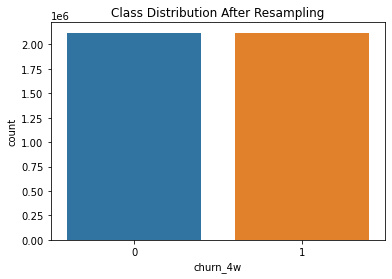

In [95]:
#resample train data, use all churn_2w = 1 and the same amount of churn_2w = 0
#Separating positive class (churn=1) and negative class (churn=0)
X_no = df_final[df_final['churn_2w'] == 0]
X_yes = df_final[df_final['churn_2w'] == 1]

#Upsampling the positive class
X_no_downsampled = X_no.sample(n=len(X_yes), replace=True, random_state=42)
print(len(X_no_downsampled))

#Combining positive and negative class and checking class distribution
X_downsampled = X_yes.append(X_no_downsampled).reset_index(drop=True)
sns.countplot('churn_2w', data=X_downsampled).set_title('Class Distribution After Resampling')

In [97]:
#normalize dataset
X = X_downsampled[[
#engagement
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w',
#features
'seniority_till_last_active', 'is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user']]
Y = X_downsampled['churn_2w'] #target 

#Scaling continuous variables:
sc = MinMaxScaler()
a = sc.fit_transform(X_downsampled[[
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active']].to_numpy())

X = pd.DataFrame(a, columns=[
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active'])

X[['is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user', 'churn_2w']] = pd.DataFrame(X_downsampled, columns = ['is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user', 'churn_2w'])

Y = X['churn_2w'] #target (dependent variable)
X = X.drop(['churn_2w'], axis=1) #features (independent variables)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [98]:
model_xg = XGBClassifier()
result = model_xg.fit(X_train, Y_train)
prediction_test = model_xg.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(Y_test, prediction_test))
print(classification_report(Y_test, prediction_test))

C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\manhdang\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:55:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8339905283706557
              precision    recall  f1-score   support

           0       0.88      0.78      0.82    424483
           1       0.80      0.89      0.84    423312

    accuracy                           0.83    847795
   macro avg       0.84      0.83      0.83    847795
weighted avg       0.84      0.83      0.83    847795



In [126]:
##not resampling
X = df_final_14aug[[
#engagement
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w',
#features
'seniority_till_last_active', 'is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user']]
Y = df_final_14aug['churn_2w'] #target 

#Scaling continuous variables:
sc = MinMaxScaler()
a = sc.fit_transform(df_final_14aug[[
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active']].to_numpy())

X = pd.DataFrame(a, columns=[
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active'])

X[['is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user', 'churn_2w']] = pd.DataFrame(df_final_14aug, columns = ['is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user', 'churn_2w'])

X = X[[
#engagement
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w',
#features
'seniority_till_last_active', 'is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user']]
Y = df_final_14aug['churn_2w'] #target 

#test with data ref.date = 14aug
prediction_test = model_xg.predict(X)
# Print the prediction accuracy
print (metrics.accuracy_score(Y, prediction_test))

print('----------------------------------------------------')

cm = confusion_matrix(prediction_test, Y)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
print('--')
print('X_yes:', sum(df_final_14aug['churn_2w'] == 1)) 
print('X_no:', sum(df_final_14aug['churn_2w'] == 0)) 

print('after upsample X_yes')

print('X_yes:', sum(X_upsampled['churn_2w'] == 1)) 
print('X_no:', sum(X_upsampled['churn_2w'] == 0)) 

print('----------------------------------------------------')

print(classification_report(Y, prediction_test))



0.8116906682669986
----------------------------------------------------
Confusion matrix

 [[871303  48831]
 [229809 329750]]

True Positives(TP) =  871303

True Negatives(TN) =  329750

False Positives(FP) =  48831

False Negatives(FN) =  229809
--
X_yes: 378581
X_no: 1101112
after upsample X_yes
X_yes: 1101112
X_no: 1101112
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.79      0.86   1101112
           1       0.59      0.87      0.70    378581

    accuracy                           0.81   1479693
   macro avg       0.77      0.83      0.78   1479693
weighted avg       0.86      0.81      0.82   1479693



In [133]:
len(prediction_test)

1479693

In [136]:
X['prediction_test'] = prediction_test
X['churn_2w'] = Y

In [137]:
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

,lad_ref.active_days_last_4w,inactive_days_till_ref,other_feature_users.total_dowload_events_last_4w,other_feature_users.total_cinema_events_last_4w,other_feature_users.total_pin_events_last_4w,other_feature_users.total_headset_events_last_4w,search_users.total_queries_last_4w,nf_users.total_clicks_last_4w,other_feature_users.total_sessions_last_4w,seniority_till_last_active,is_dowload_user,is_cinema_user,is_pin_user,is_headset_user,is_search_user,is_nf_user,prediction_test,churn_4w
0,0.148148,0.074074,0.000155,0.00000,0.0,0.0,0.000000,0.0,0.001422,0.188136,1,0,0,0,0,0,0,0
1,0.888889,0.000000,0.000000,0.00000,0.0,0.0,0.010695,0.0,0.014216,0.111864,0,0,0,0,1,1,0,0
2,0.000000,0.962963,0.000006,0.00000,0.0,0.0,0.001035,0.0,0.001422,1.000000,1,0,0,0,1,0,1,1
3,0.370370,0.111111,0.000000,0.00000,0.0,0.0,0.000518,0.0,0.001828,0.437288,0,0,0,0,1,1,0,0
4,1.000000,0.000000,0.000000,0.02141,0.0,0.0,0.009833,0.0,0.021121,0.094915,0,1,0,0,1,1,0,0


In [ ]:
X.head()

1101112


C:\Users\manhdang\AppData\Local\Temp\ipykernel_6488\544953251.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
C:\Users\manhdang\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distribution After Resampling')

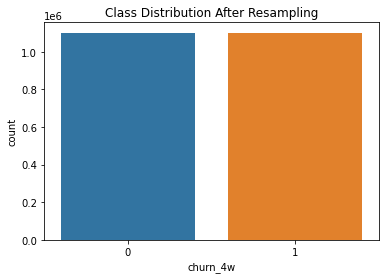

In [102]:
##resembling
#resample train data, use all churn_2w = 1 and the same amount of churn_2w = 0
#Separating positive class (churn=1) and negative class (churn=0)
X_no = df_final_14aug[df_final_14aug['churn_2w'] == 0]
X_yes = df_final_14aug[df_final_14aug['churn_2w'] == 1]

#Upsampling the positive class
X_yes_upsampled = X_yes.sample(n=len(X_no), replace=True, random_state=42)
print(len(X_yes_upsampled))

#Combining positive and negative class and checking class distribution
X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
sns.countplot('churn_2w', data=X_upsampled).set_title('Class Distribution After Resampling')

In [109]:
#Scaling continuous variables:
sc = MinMaxScaler()
a = sc.fit_transform(X_upsampled[[
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active']].to_numpy())

X = pd.DataFrame(a, columns=[
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w', 'seniority_till_last_active'])

X[['is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user', 'churn_2w']] = pd.DataFrame(X_upsampled, columns = ['is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user', 'churn_2w'])

X = X[[
#engagement
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'other_feature_users.total_sessions_last_4w',
#features
'seniority_till_last_active', 'is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user']]
Y = X_upsampled['churn_2w'] #target 


In [108]:
X_upsampled

,index,browser_id,churn_4w,churn_current,lad_ref.last_active_date,lad_4w_past_ref.last_active_date,lad_current.last_active_date,lad_ref.first_active_date_2022,first_active_date,lad_ref.active_days_last_4w,...,is_headset_user,is_search_user,is_nf_user,other_feature_users.total_sessions_last_4w,other_feature_users.total_dowload_events_last_4w,other_feature_users.total_cinema_events_last_4w,other_feature_users.total_pin_events_last_4w,other_feature_users.total_headset_events_last_4w,search_users.total_queries_last_4w,nf_users.total_clicks_last_4w
0,0,0dfb67fc-fb13-b1c0-5eab-d94415756cec.ORKBfH8zP...,0,0,2022-08-12,2022-09-01,2022-09-01,2022-08-06,2022-04-23,5,...,0,0,0,7,80,0,0,0,0,0
1,1,24d5cab8-fed2-7f00-1594-5f394b5b5a8b.6H4vj7N6c...,0,0,2022-08-14,2022-09-11,2022-09-22,2022-07-18,2022-06-09,25,...,0,1,1,70,0,0,0,0,62,0
2,3,c2e5f204-974d-4bf9-355b-659ed726635f.qOd4XvEhC...,0,0,2022-08-11,2022-09-11,2022-09-20,2022-07-22,2021-11-26,11,...,0,1,1,9,0,0,0,0,3,0
3,4,886095cd-734c-6fa2-f734-477efa56186e.ImEpllDgM...,0,0,2022-08-14,2022-09-11,2022-09-22,2022-07-18,2022-06-19,28,...,0,1,1,104,0,92,0,0,57,0
4,6,0dfaf0b5-e882-9271-e940-455b45770009.G02yYxKei...,0,0,2022-08-13,2022-09-11,2022-09-22,2022-07-19,2022-04-11,19,...,1,1,1,97,0,0,2,35,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202219,474433,a0af5663-43e4-97fc-ed98-31f630192572.6-o9Ii2Yn...,1,1,2022-08-13,2022-08-13,2022-08-13,2022-08-13,2021-09-12,1,...,0,1,1,1,0,0,0,0,4,0
2202220,1080241,952f869d-f056-525c-65c1-9d0025981dd3.5D12xci48...,1,1,2022-07-27,2022-07-27,2022-07-27,2022-07-18,2022-01-26,6,...,0,0,1,6,0,0,0,0,0,0
2202221,170040,34ed9e49-93c4-7499-d8e3-42cafb167e8d.pQkkVYGf1...,1,1,2022-08-07,2022-08-07,2022-08-07,2022-07-31,2022-07-31,6,...,0,0,1,6,1,1,0,0,0,0
2202222,752847,1386f153-82eb-7d4e-273f-9157f0d1f348.rd2bnXqRl...,1,1,2022-08-11,2022-08-11,2022-08-11,2022-07-18,2022-07-15,6,...,0,1,1,8,0,0,0,0,5,0


In [110]:
#test with data ref.date = 14aug
prediction_test = model_xg.predict(X)
# Print the prediction accuracy
print (metrics.accuracy_score(Y, prediction_test))

print('----------------------------------------------------')

cm = confusion_matrix(Y, prediction_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

print('----------------------------------------------------')

print(classification_report(Y, prediction_test))

0.8313350503854285
----------------------------------------------------
Confusion matrix

 [[871303 229809]
 [141629 959483]]

True Positives(TP) =  871303

True Negatives(TN) =  959483

False Positives(FP) =  229809

False Negatives(FN) =  141629
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.79      0.82   1101112
           1       0.81      0.87      0.84   1101112

    accuracy                           0.83   2202224
   macro avg       0.83      0.83      0.83   2202224
weighted avg       0.83      0.83      0.83   2202224



In [39]:
#RidgeClassifier
from sklearn.linear_model import RidgeClassifier
clf_ridge = RidgeClassifier() #create a ridge classifier object
clf_ridge.fit(X_train, Y_train) #train the model

prediction_test = clf_ridge.predict(X_test)
print (metrics.accuracy_score(Y_test, prediction_test))

0.8050431396335219


In [40]:
cm = confusion_matrix(Y_test, prediction_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[176260  51421]
 [ 37291 190062]]

True Positives(TP) =  176260

True Negatives(TN) =  190062

False Positives(FP) =  51421

False Negatives(FN) =  37291


In [41]:
print(classification_report(Y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80    227681
           1       0.79      0.84      0.81    227353

    accuracy                           0.81    455034
   macro avg       0.81      0.81      0.80    455034
weighted avg       0.81      0.81      0.80    455034



In [42]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_forest.fit(X_train, Y_train)

prediction_test = clf_forest.predict(X_test)
print (metrics.accuracy_score(Y_test, prediction_test))

0.8276700202622221


In [43]:
cm = confusion_matrix(Y_test, prediction_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[175028  52653]
 [ 25763 201590]]

True Positives(TP) =  175028

True Negatives(TN) =  201590

False Positives(FP) =  52653

False Negatives(FN) =  25763


In [44]:
print(classification_report(Y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82    227681
           1       0.79      0.89      0.84    227353

    accuracy                           0.83    455034
   macro avg       0.83      0.83      0.83    455034
weighted avg       0.83      0.83      0.83    455034



In [45]:
#Gradient Boosting algorithm
#compute the accuracy scores on train and validation sets when training with different learning rates
from sklearn.ensemble import GradientBoostingClassifier

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, Y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, Y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, Y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.782
Accuracy score (validation): 0.782

Learning rate:  0.1
Accuracy score (training): 0.788
Accuracy score (validation): 0.788

Learning rate:  0.25
Accuracy score (training): 0.793
Accuracy score (validation): 0.794

Learning rate:  0.5
Accuracy score (training): 0.807
Accuracy score (validation): 0.808

Learning rate:  0.75
Accuracy score (training): 0.809
Accuracy score (validation): 0.811

Learning rate:  1
Accuracy score (training): 0.808
Accuracy score (validation): 0.809



In [46]:
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.75, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, Y_train)
prediction_test = gb.predict(X_test)
print (metrics.accuracy_score(Y_test, prediction_test))

0.8107460101882497


In [47]:
cm = confusion_matrix(Y_test, prediction_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[174069  53612]
 [ 32505 194848]]

True Positives(TP) =  174069

True Negatives(TN) =  194848

False Positives(FP) =  53612

False Negatives(FN) =  32505


In [48]:
print(classification_report(Y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80    227681
           1       0.78      0.86      0.82    227353

    accuracy                           0.81    455034
   macro avg       0.81      0.81      0.81    455034
weighted avg       0.81      0.81      0.81    455034



In [85]:
X = df_final_27feb[[
#engagement
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'total_sessions_last_4w',
#features
'seniority_till_last_active', 'is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user']]
Y = df_final_27feb['churn_2w'] #target 

In [86]:
from sklearn import metrics
prediction_test = model.predict(X)
# Print the prediction accuracy
print (metrics.accuracy_score(Y, prediction_test))

0.45756847853096905


In [6]:
#using pycaret to train with multiple algorithms
from pycaret.classification import *

In [4]:
data = df_final_30jan[[
#engagement
'lad_ref.active_days_last_4w', 'inactive_days_till_ref', 'other_feature_users.total_dowload_events_last_4w', 
'other_feature_users.total_cinema_events_last_4w', 'other_feature_users.total_pin_events_last_4w',
'other_feature_users.total_headset_events_last_4w', 'search_users.total_queries_last_4w', 
'nf_users.total_clicks_last_4w', 'total_sessions_last_4w',
#features
'seniority_till_last_active', 'is_dowload_user', 'is_cinema_user', 'is_pin_user', 
'is_headset_user', 'is_search_user', 'is_nf_user',
#targe
'churn_2w']]

In [7]:
s = setup(data, target = 'churn_2w')

,Description,Value
0,Session id,5474
1,Target,churn_2w
2,Target type,Binary
3,Original data shape,"(1609142, 17)"
4,Transformed data shape,"(1609142, 17)"
5,Transformed train set shape,"(1126399, 17)"
6,Transformed test set shape,"(482743, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:59:20
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8152,0.8851,0.7266,0.7452,0.7357,0.5937,0.5939,13.4320


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [134]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0.0, 120769), (1.0, 120769)]


In [ ]:
from imblearn.over_sampling import SVMSMOTE
oversample = SVMSMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

In [100]:
from imblearn.over_sampling import SMOTE

In [101]:
oversample = SMOTE()
x_train_res, y_train_re = oversample.fit_resample(X_train, y_train)

In [102]:
x_train_res

,first_date1,last_date1,active_days_last_week,clicks,CC_queries,GG_queries,active_time_per_day,use_pip,use_download,open_noti,serp_show,skin_show,youtube_clicks,coccoc_clicks,google_clicks,facebook_clicks,vnexpress_clicks,vlxx_clicks
0,355,0,7,1.000000,0.000000,0.000000,4.216667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,161,0,7,22.000000,0.000000,0.000000,289.133333,0.000000,8.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,395,0,4,20.000000,5.000000,0.000000,4.566667,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,9.000000,0.000000,0.0,0.0,0.000000
3,378,4,1,30.000000,3.000000,0.000000,24.466667,0.000000,0.000000,0.000000,6.000000,0.000000,0.0,5.000000,0.000000,0.0,0.0,0.000000
4,236,0,7,1369.000000,0.000000,0.000000,0.000000,0.000000,2178.000000,0.000000,0.000000,0.000000,0.0,0.000000,333.000000,0.0,349.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307881,39,1,1,5.156180,1.000000,0.000000,1.901911,0.000000,8.156180,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.0,0.0,0.000000
3307882,243,4,1,89.576538,0.898324,54.389945,13.699443,0.000000,0.898324,0.203352,1.796648,0.000000,0.0,1.796648,56.406703,0.0,0.0,0.898324
3307883,246,3,1,2.493259,0.000000,0.000000,1.930187,0.000000,1.493259,0.506741,0.000000,0.000000,0.0,0.493259,0.000000,0.0,0.0,0.000000
3307884,150,2,2,184.886869,2.301891,7.481145,0.000000,0.424527,226.594276,0.000000,1.726418,0.849055,0.0,5.179254,7.481145,0.0,0.0,138.000000


In [135]:
from xgboost import XGBClassifier

In [136]:
model = XGBClassifier()

model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.16%


In [137]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[ 51912   7761]
 [ 64550 206846]]

True Positives(TP) =  51912

True Negatives(TN) =  206846

False Positives(FP) =  7761

False Negatives(FN) =  64550


In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.45      0.87      0.59     59673
         1.0       0.96      0.76      0.85    271396

    accuracy                           0.78    331069
   macro avg       0.70      0.82      0.72    331069
weighted avg       0.87      0.78      0.80    331069



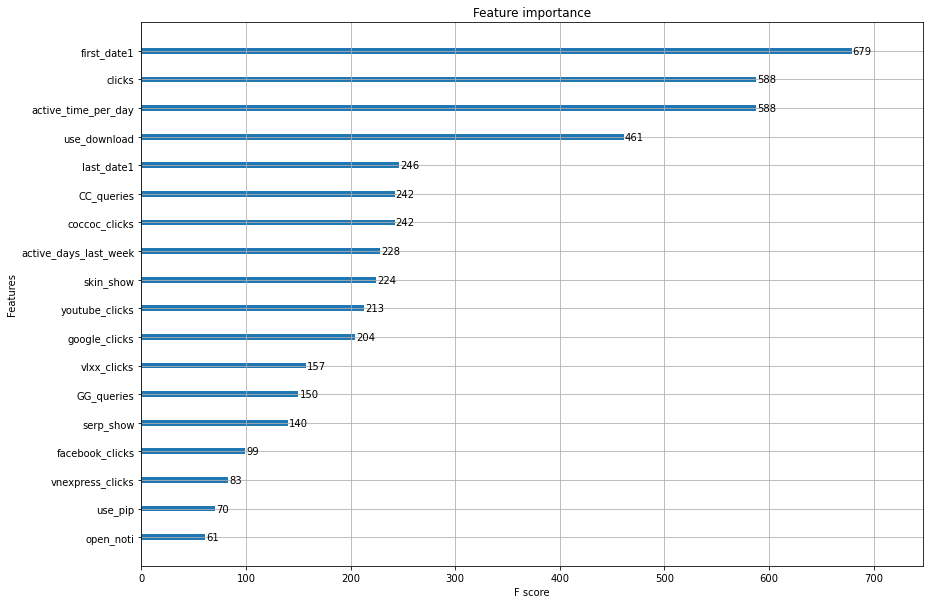

In [139]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 10)
plot_importance(model)

In [11]:
sm = SMOTE(random_state=7, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

AttributeError: 'SMOTE' object has no attribute 'fit_sample'

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=12)

total class of active and churn: 1.0    822795
0.0    822795
Name: output, dtype: int64


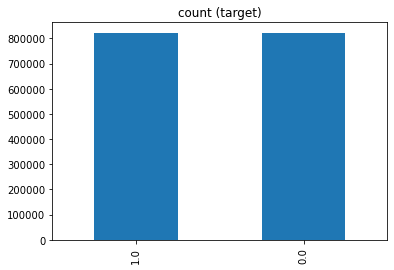

In [171]:
df_churn = df_final[df_final['output'] == 0]
df_active = df_final[df_final['output'] == 1]
df_active_count,df_churn_count = df_final['output'].value_counts()
df_churn_over = df_churn.sample(df_active_count, replace=True)
test_over = pd.concat([df_churn_over, df_active], axis=0)
print("total class of active and churn:",test_over['output'].value_counts())# plot the count after under-sampeling
test_over['output'].value_counts().plot(kind='bar', title='count (target)')

In [172]:
browser_id = test_over['browser_id']

In [173]:
X = test_over.drop(columns={'output','browser_id'})

Y = test_over['output']

In [174]:
import pickle

In [175]:
loaded_model = pickle.load(open("Android.pickle.dat", "rb"))
print("Loaded model from: Android.pickle.dat")

Loaded model from: Android.pickle.dat


In [176]:
predictions = loaded_model.predict(X)

In [177]:
from sklearn.metrics import accuracy_score

In [178]:
accuracy = accuracy_score(Y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.60%


In [179]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, predictions)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[711103 111692]
 [191020 631775]]

True Positives(TP) =  711103

True Negatives(TN) =  631775

False Positives(FP) =  111692

False Negatives(FN) =  191020


In [180]:
from sklearn.metrics import classification_report
print(classification_report(Y, predictions))

              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82    822795
         1.0       0.85      0.77      0.81    822795

    accuracy                           0.82   1645590
   macro avg       0.82      0.82      0.82   1645590
weighted avg       0.82      0.82      0.82   1645590



In [184]:
len(predictions)

1645590

In [187]:
test_over['prediction'] = predictions

In [190]:
df_final

,browser_id,first_date1,last_date1,active_days_last_week,clicks,CC_queries,GG_queries,active_time_per_day,use_pip,use_download,open_noti,serp_show,skin_show,youtube_clicks,coccoc_clicks,google_clicks,facebook_clicks,vnexpress_clicks,vlxx_clicks,output
0,5367df76-f215-b8ab-25f6-6a902fafe684.nW0paNONt...,93,0,7,216.0,8.0,0.0,0.000000,0.0,0.0,0.0,0.0,13.0,175.0,11.0,0.0,0.0,0.0,0.0,1.0
1,8df67406-6f66-7599-54dc-f7bee797317f.4v6Xst6nT...,474,0,7,505.0,19.0,3.0,584.500000,0.0,513.0,0.0,0.0,0.0,0.0,22.0,7.0,0.0,116.0,0.0,1.0
2,5ed72c63-93e4-c363-f569-b6add7c177fb.LNhdbkKzO...,282,0,7,849.0,0.0,0.0,0.000000,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,9784c6a1-72e0-d985-5360-97793b34c9bc.2EUD-ByiS...,279,0,7,43.0,4.0,0.0,162.783333,0.0,139.0,1.0,0.0,3.0,2.0,8.0,0.0,1.0,0.0,0.0,1.0
4,3f379503-103b-66de-c5b9-ddf46342e7d5.349vz3tK8...,431,0,7,294.0,14.0,0.0,0.000000,0.0,92.0,0.0,5.0,0.0,0.0,19.0,0.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003232,f4918ceb-47ea-45be-90bb-eaa2f17fe2f9.X04RhgYt2...,468,0,1,32.0,0.0,0.0,50.283333,0.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1003233,e64d1398-be51-685d-e831-7823d43cabfa.Zvw4FF179...,157,0,1,2.0,0.0,0.0,0.216667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1003234,ac22002e-53d3-ed48-b39a-08cc4f5c084f.AZKzzSgod...,416,0,1,11.0,0.0,0.0,0.166667,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
1003235,dfd91568-3061-43fd-add4-b140772ba701.rl28UIlFN...,472,0,1,3.0,0.0,0.0,0.950000,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [191]:
abc = test_over.drop_duplicates()

In [192]:
Y = abc['output']
predictions = abc['prediction']

In [193]:
accuracy = accuracy_score(Y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.50%


In [194]:
from sklearn.metrics import classification_report
print(classification_report(Y, predictions))

              precision    recall  f1-score   support

         0.0       0.45      0.86      0.59    178502
         1.0       0.96      0.77      0.85    822795

    accuracy                           0.78   1001297
   macro avg       0.70      0.82      0.72   1001297
weighted avg       0.87      0.78      0.81   1001297



In [44]:
df_churn = df_final[df_final['output'] == 0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017D01C95D00>,
      dtype=object)

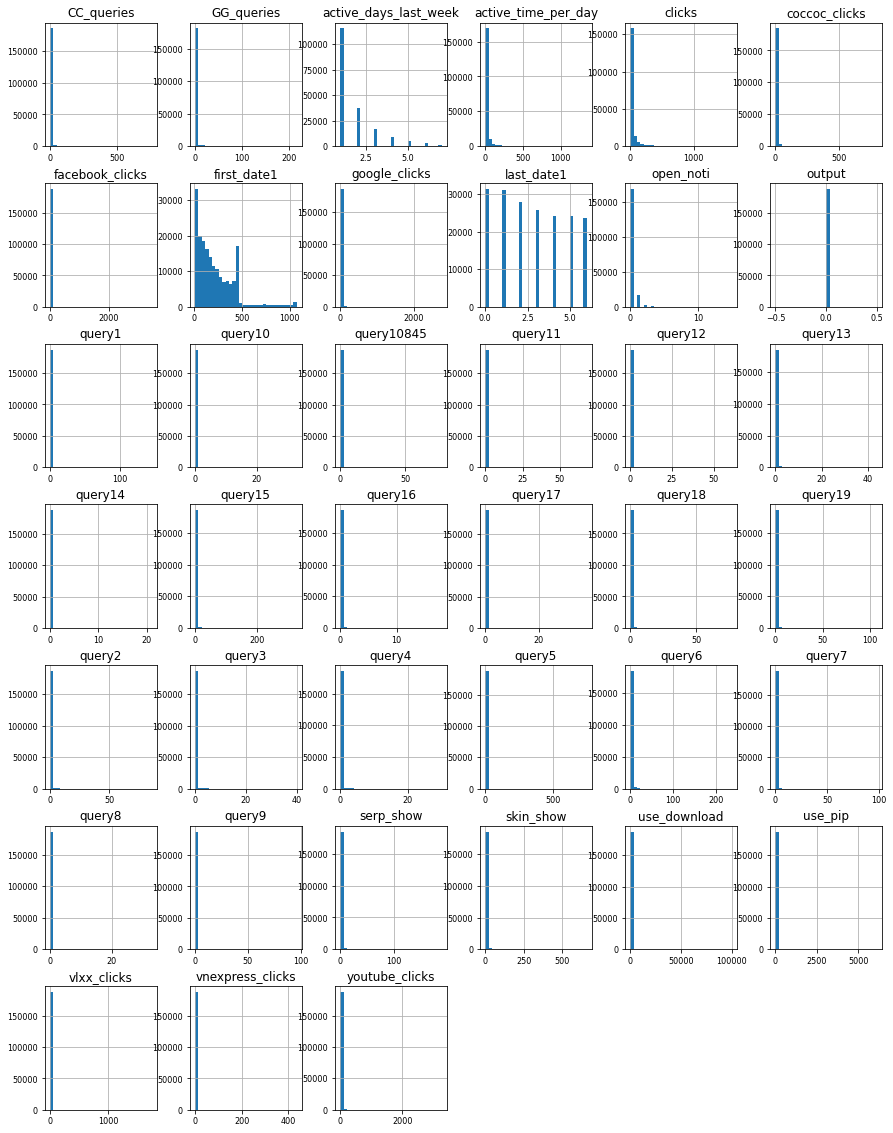

In [45]:
df_churn.hist(figsize=(15, 20), bins=30, xlabelsize=8, ylabelsize=8)

In [46]:
df_active = df_final[df_final['output'] == 1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017D3EBCCD60>,
      dtype=object)

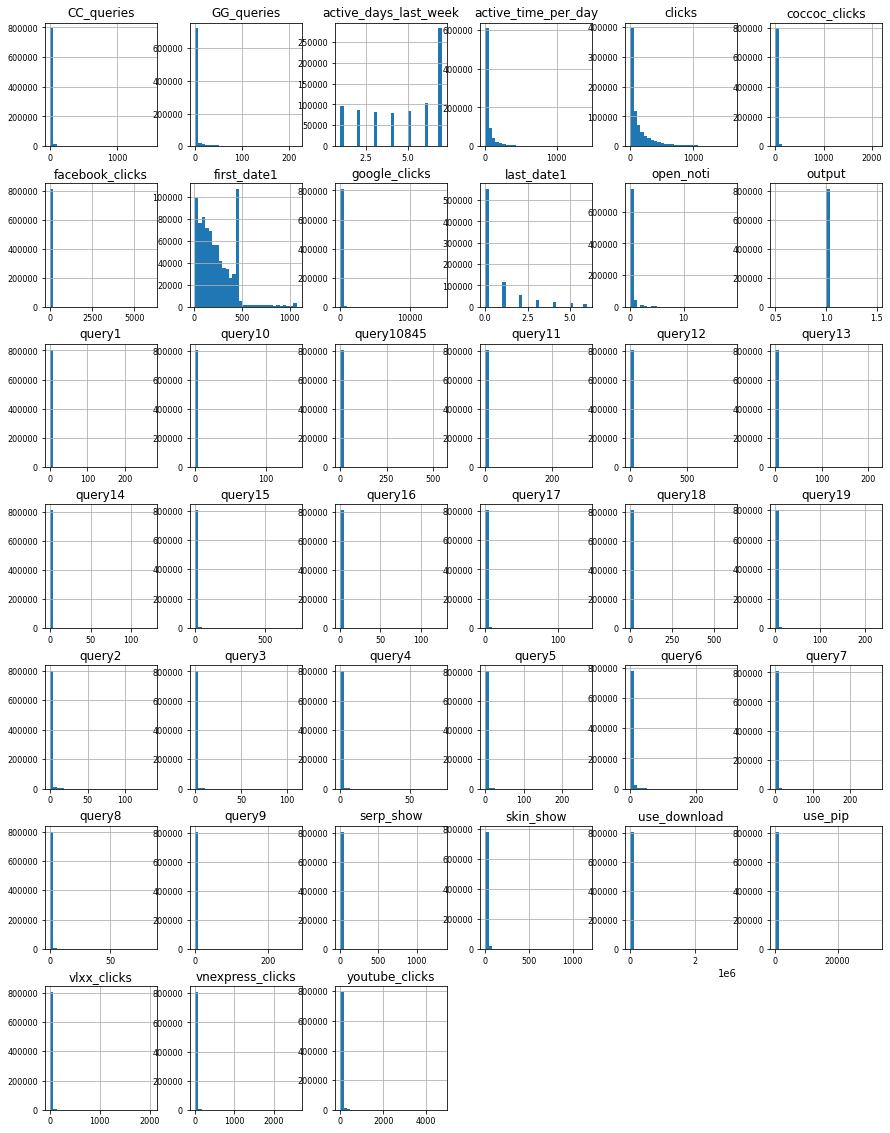

In [47]:
df_active.hist(figsize=(15, 20), bins=30, xlabelsize=8, ylabelsize=8)

In [48]:
df_churn.describe()

,first_date1,last_date1,active_days_last_week,clicks,CC_queries,GG_queries,query1,query2,query3,query4,...,open_noti,serp_show,skin_show,youtube_clicks,coccoc_clicks,google_clicks,facebook_clicks,vnexpress_clicks,vlxx_clicks,output
count,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,...,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.000000,188009.0
mean,218.393449,2.784292,1.750028,39.427166,2.269508,1.368169,0.094692,0.066694,0.033621,0.021079,...,0.134616,0.405076,1.850640,2.518023,3.001984,2.778165,0.522773,0.153466,0.737901,0.0
std,197.352221,2.008300,1.232462,108.718677,6.972305,9.597295,1.136224,0.743748,0.351800,0.263456,...,0.446692,2.312077,6.184233,22.052718,9.017130,25.618078,11.276801,2.598282,9.756075,0.0
min,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,67.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,162.000000,3.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,333.000000,5.000000,2.000000,28.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1073.000000,6.000000,7.000000,1606.000000,752.000000,215.000000,145.000000,86.000000,40.000000,30.000000,...,15.000000,188.000000,658.000000,3262.000000,802.000000,2753.000000,3444.000000,436.000000,1749.000000,0.0


In [49]:
df_active.describe()

,first_date1,last_date1,active_days_last_week,clicks,CC_queries,GG_queries,query1,query2,query3,query4,...,open_noti,serp_show,skin_show,youtube_clicks,coccoc_clicks,google_clicks,facebook_clicks,vnexpress_clicks,vlxx_clicks,output
count,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,...,811911.000000,811911.00000,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,811911.000000,811911.0
mean,229.077760,0.741449,4.739321,154.114751,7.280066,5.369193,0.362870,0.263191,0.148919,0.107379,...,0.159271,1.44554,6.433959,11.482128,9.579921,13.323519,1.948077,1.562597,2.301075,1.0
std,176.051773,1.387770,2.185163,240.813190,15.537713,20.722261,2.547121,1.429651,0.878339,0.756300,...,0.709634,6.00970,16.647400,67.835644,21.903663,75.225218,32.053107,14.889600,16.711152,0.0
min,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,90.000000,0.000000,3.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,190.000000,0.000000,5.000000,57.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,348.000000,1.000000,7.000000,185.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,6.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.0
max,1073.000000,6.000000,7.000000,1607.000000,1512.000000,216.000000,271.000000,135.000000,110.000000,73.000000,...,19.000000,1326.00000,1160.000000,4717.000000,2108.000000,14569.000000,6007.000000,2584.000000,2037.000000,1.0


In [50]:
df_active_count,df_churn_count = df_final['output'].value_counts()

In [51]:
df_active_count

811911

In [52]:
df_churn_count

188009

total class of active and churn: 1.0    811911
0.0    811911
Name: output, dtype: int64


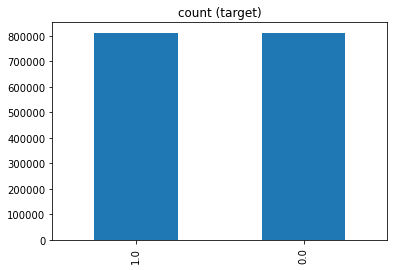

In [53]:
df_churn_over = df_churn.sample(df_active_count, replace=True)

test_over = pd.concat([df_churn_over, df_active], axis=0)

print("total class of active and churn:",test_over['output'].value_counts())# plot the count after under-sampeling
test_over['output'].value_counts().plot(kind='bar', title='count (target)')

In [54]:
test_over

,browser_id,first_date1,last_date1,active_days_last_week,clicks,CC_queries,GG_queries,query1,query2,query3,...,open_noti,serp_show,skin_show,youtube_clicks,coccoc_clicks,google_clicks,facebook_clicks,vnexpress_clicks,vlxx_clicks,output
446365,1fc89bba-ec75-b0d2-f41a-f0a116c5577e.ELoxulslg...,11,1,3,299.0,12.0,180.0,0.0,0.0,2.0,...,0.0,0.0,4.0,15.0,16.0,187.0,0.0,0.0,4.0,0.0
704706,9e10ceca-8a8e-8f35-a6f4-a7e26629b1ca.1Je1HBZoV...,302,2,2,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
854697,dfd97e77-beb7-129c-c558-45129f3e2538.p-7SefLEh...,178,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439641,abda96a0-c2fe-8c0b-ba1a-883c52b7c220.SQbHXoQkn...,55,0,5,1131.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,12.0,0.0,0.0,0.0,135.0,0.0
502264,553b0f3a-f3fa-4abe-99b5-0c9ebb6ddd08.VcCflOUKL...,367,4,1,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999907,cbb08dc6-2d2f-fbc8-0d47-294ee0e86e6f.nn4btAqB8...,43,0,1,147.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0.0,1.0
999909,03f744c9-4ed6-4808-4282-73787b4f6c5d.VTPqObSOz...,281,0,1,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
999911,71d4e00e-3637-456a-e324-7588edd5d30f.x0Fw2ff-b...,215,0,1,12.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
999913,4d2859ea-d27b-1a68-94c5-8491661c8074.uSf6ReCZF...,291,0,1,136.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,1.0


In [55]:
X = test_over.drop(columns={'output','browser_id'})

Y = test_over['output']

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [59]:
from xgboost import XGBClassifier

In [63]:
model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[234738  33818]
 [ 62576 204730]]

True Positives(TP) =  234738

True Negatives(TN) =  204730

False Positives(FP) =  33818

False Negatives(FN) =  62576


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83    268556
         1.0       0.86      0.77      0.81    267306

    accuracy                           0.82    535862
   macro avg       0.82      0.82      0.82    535862
weighted avg       0.82      0.82      0.82    535862



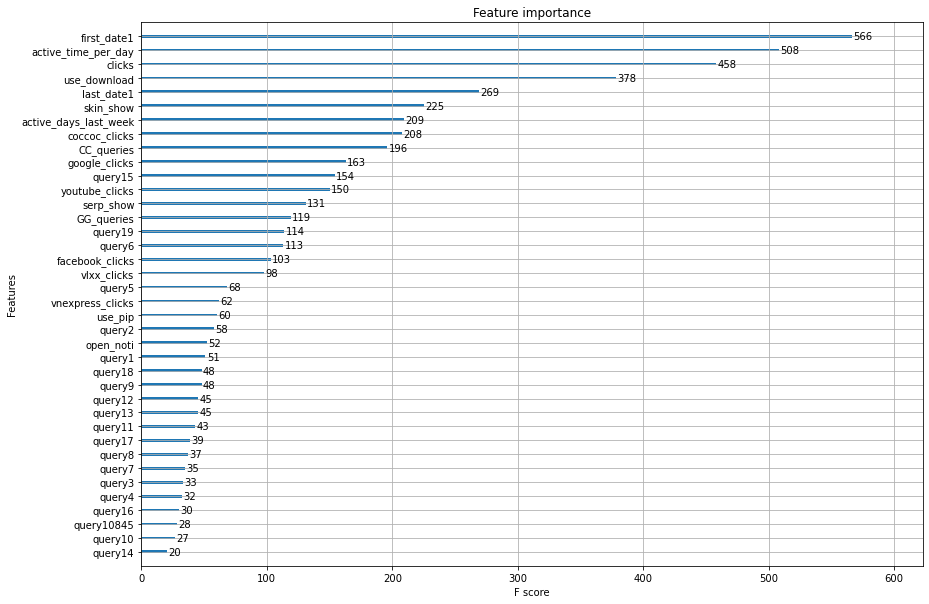

In [102]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 10)
plot_importance(model)

In [75]:
# Fit model using each importance as a threshold
from numpy import sort
thresholds = sort(model.feature_importances_)

In [104]:
from sklearn.feature_selection import SelectFromModel

In [105]:
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.002, n=38, Accuracy: 82.01%
Thresh=0.002, n=37, Accuracy: 82.01%
Thresh=0.002, n=36, Accuracy: 82.01%
Thresh=0.002, n=35, Accuracy: 81.98%
Thresh=0.002, n=34, Accuracy: 82.01%
Thresh=0.002, n=33, Accuracy: 81.96%
Thresh=0.002, n=32, Accuracy: 81.99%
Thresh=0.002, n=31, Accuracy: 81.96%
Thresh=0.002, n=30, Accuracy: 81.99%
Thresh=0.002, n=29, Accuracy: 81.99%
Thresh=0.002, n=28, Accuracy: 81.98%
Thresh=0.002, n=27, Accuracy: 82.00%
Thresh=0.002, n=26, Accuracy: 81.96%
Thresh=0.002, n=25, Accuracy: 81.98%
Thresh=0.002, n=24, Accuracy: 81.97%
Thresh=0.002, n=23, Accuracy: 82.01%
Thresh=0.003, n=22, Accuracy: 81.97%
Thresh=0.003, n=21, Accuracy: 81.97%
Thresh=0.003, n=20, Accuracy: 81.96%
Thresh=0.003, n=19, Accuracy: 81.94%
Thresh=0.003, n=18, Accuracy: 81.93%
Thresh=0.003, n=17, Accuracy: 81.92%
Thresh=0.003, n=16, Accuracy: 81.92%
Thresh=0.003, n=15, Accuracy: 81.91%
Thresh=0.003, n=14, Accuracy: 81.93%
Thresh=0.003, n=13, Accuracy: 81.92%
Thresh=0.003, n=12, Accuracy: 81.91%
T

In [106]:
test_over

,browser_id,first_date1,last_date1,active_days_last_week,clicks,CC_queries,GG_queries,query1,query2,query3,...,open_noti,serp_show,skin_show,youtube_clicks,coccoc_clicks,google_clicks,facebook_clicks,vnexpress_clicks,vlxx_clicks,output
446365,1fc89bba-ec75-b0d2-f41a-f0a116c5577e.ELoxulslg...,11,1,3,299.0,12.0,180.0,0.0,0.0,2.0,...,0.0,0.0,4.0,15.0,16.0,187.0,0.0,0.0,4.0,0.0
704706,9e10ceca-8a8e-8f35-a6f4-a7e26629b1ca.1Je1HBZoV...,302,2,2,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
854697,dfd97e77-beb7-129c-c558-45129f3e2538.p-7SefLEh...,178,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
439641,abda96a0-c2fe-8c0b-ba1a-883c52b7c220.SQbHXoQkn...,55,0,5,1131.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,12.0,0.0,0.0,0.0,135.0,0.0
502264,553b0f3a-f3fa-4abe-99b5-0c9ebb6ddd08.VcCflOUKL...,367,4,1,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999907,cbb08dc6-2d2f-fbc8-0d47-294ee0e86e6f.nn4btAqB8...,43,0,1,147.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0.0,1.0
999909,03f744c9-4ed6-4808-4282-73787b4f6c5d.VTPqObSOz...,281,0,1,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
999911,71d4e00e-3637-456a-e324-7588edd5d30f.x0Fw2ff-b...,215,0,1,12.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
999913,4d2859ea-d27b-1a68-94c5-8491661c8074.uSf6ReCZF...,291,0,1,136.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,1.0


In [108]:
test_over1 = test_over.drop(columns=['query1', 'query2','query3','query4','query5','query6','query7','query8','query9','query10','query11','query12','query13','query14','query15','query16','query17','query18','query19','query10845'])

In [109]:
X = test_over1.drop(columns={'output','browser_id'})

Y = test_over1['output']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [111]:
model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.95%


In [112]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[234593  33963]
 [ 62761 204545]]

True Positives(TP) =  234593

True Negatives(TN) =  204545

False Positives(FP) =  33963

False Negatives(FN) =  62761


In [113]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83    268556
         1.0       0.86      0.77      0.81    267306

    accuracy                           0.82    535862
   macro avg       0.82      0.82      0.82    535862
weighted avg       0.82      0.82      0.82    535862



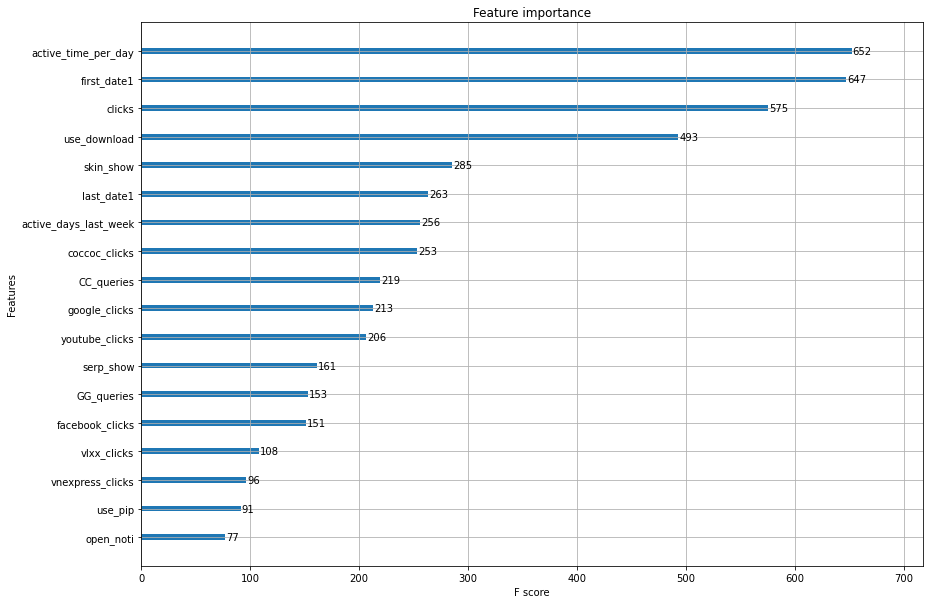

In [114]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 10)
plot_importance(model)

In [126]:
import pickle

In [127]:
pickle.dump(model, open("Android.pickle.dat", "wb"))
print("Saved model to: Android.pickle.dat")

Saved model to: Android.pickle.dat
